# Star 

## Packages

In [1]:
import numpy as np
from numpy import correlate
import matplotlib.pyplot as plt
import skysimulation.display as dpl
import skysimulation.stuff as stf
import skysimulation.field as fld
import skysimulation.restoration as rst
from skysimulation.stuff import NDArray, sqr_mask, ArrayLike

## Sky Generation

### Initial Parameters

In [11]:
mass_seed = fld.M_SEED
pos_seed  = fld.POS_SEED
bkg_seed  = fld.BACK_SEED
det_seed  = fld.NOISE_SEED
# mass_seed = None
# pos_seed  = None
# bkg_seed  = None
# det_seed  = None
method = 'rl'
# method = None
last_sen = []

kwargs = {}

### Sky

----------
Initialization of the field
Dimension:	100 x 100
Number of stars:	100

- - - Background - - -
Gaussian distribution
mean:	0.5
sigma:	0.1

- - - Detector noise - - -
Gaussian distribution
mean:	0.05
sigma:	0.025

Atm Seeing:
Gaussian distribution
sigma:	3


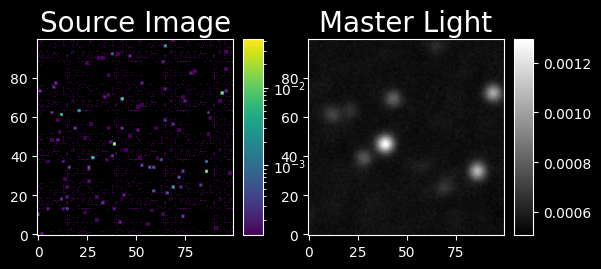

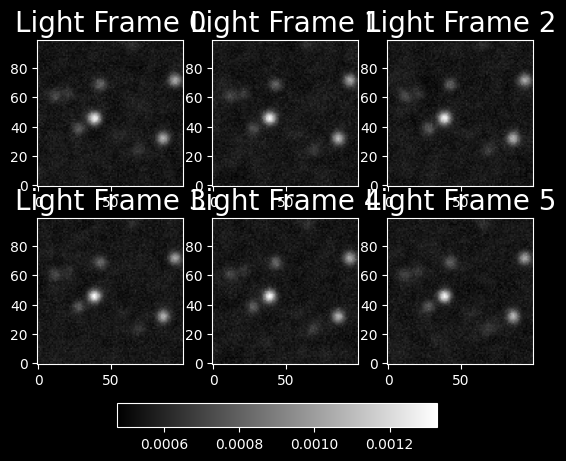

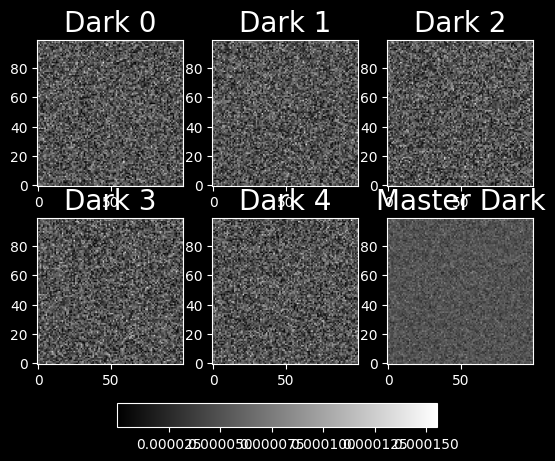

SIGMA = 1.477814488487309e-05 +- 3.3777894535859476e-06


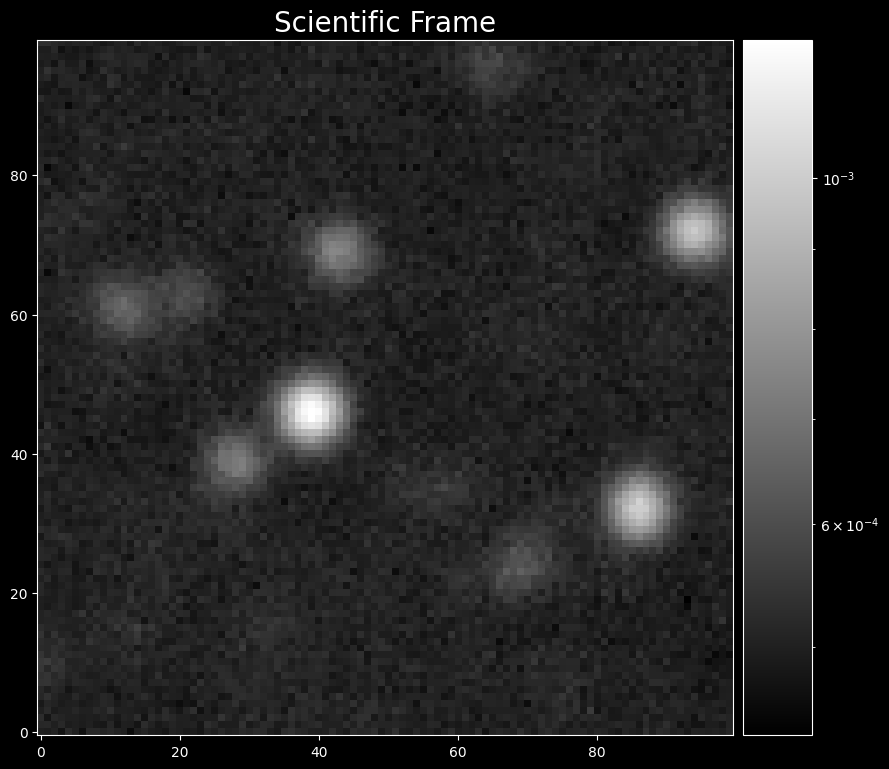

!!CHECK!!	 39


In [10]:
# generate the field
S, (m_light, s_light), (m_dark, s_dark) = fld.field_builder(seed=(mass_seed,pos_seed), back_seed=bkg_seed, det_seed=det_seed,**kwargs)
last_sen += [f'L0: {S.lum.max()}\nL0.5: {m_light.max()*np.sqrt(18*np.pi)}']
# compute the scientific frame
sci_frame = m_light - m_dark
last_sen += [f'L1: {sci_frame.max()*np.sqrt(18*np.pi)}']
# compute the uncertainty
sigma = np.sqrt(s_light**2 + s_dark**2)
m_sigma = sigma.mean()
s_sigma = sigma.std()
print(f'SIGMA = {m_sigma} +- {s_sigma}')
dpl.fast_image(sci_frame,'Scientific Frame',norm='log')
print('!!CHECK!!\t',len(np.where(S.lum > fld.BACK_MEAN*fld.K)[0]))


## Restoration

### Background Estimation


Background estimation
	mean:	0.0005071506961961496
	sigma:	1.9122512788727344e-05
	relerr:	3.77 %
Back 0.0005 0.0001
0.0005071506961961496
2.1447941163342834e-05
0.0005753232002239909


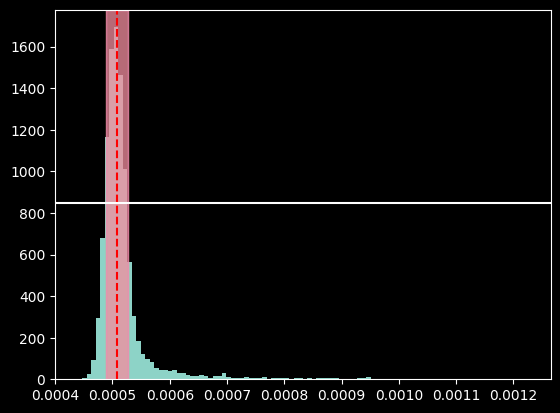

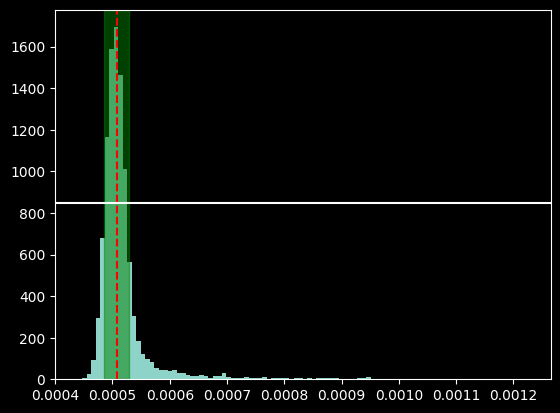

In [12]:
max_size = 5
# compute the average dark value
mean_dark = m_dark.mean()
# estimate background value
m_bkg, sigma_bkg = rst.bkg_est(sci_frame)
mean_bkg, Dmean_bkg = m_bkg
print('Back',fld.BACK_MEAN*fld.K, fld.BACK_SIGMA*fld.K)
med = np.median(sci_frame)
var = np.sqrt(np.var(sci_frame[sci_frame<6e-4],ddof=1))
print(med)
print(var)
print(2*med-sci_frame.min())
plt.figure()
valbin,_,_ = plt.hist(sci_frame.flatten(),sci_frame.shape[0])
plt.axvline(mean_bkg,0,1,color='red',linestyle='dashed')
plt.axvspan(mean_bkg-sigma_bkg,mean_bkg+sigma_bkg,color='orange',alpha=0.5)
plt.axvspan(mean_bkg-Dmean_bkg,mean_bkg+Dmean_bkg,color='violet',alpha=0.5)
plt.axhline(valbin.max()/2,0,1)
plt.figure()
valbin,_,_ = plt.hist(sci_frame.flatten(),sci_frame.shape[0])
plt.axvline(med,0,1,color='red',linestyle='dashed')
plt.axvspan(med-var,med+var,color='green',alpha=0.5)
plt.axhline(valbin.max()/2,0,1)
plt.show()

### Kernel Estimation

#### New Searching

In [13]:


def art_obj(prb_obj: NDArray, index: tuple[int,int], bkg_val: float, errs: NDArray | None = None, ker_sigma: float | None = None) -> tuple[NDArray,NDArray] | tuple[None,None]:
    fit_obj = prb_obj.copy() - bkg_val
    # prb_x, prb_y = index
    avg_cen = index 
    def gauss_func(pos, *args):
        xpos, ypos = pos
        k, s, x0, y0 = args
        zx = (xpos-x0)/s
        zy = (ypos-y0)/s
        return k * np.exp(-zx**2/2) * np.exp(-zy**2/2)
    xdim, ydim = prb_obj.shape
    xrange, yrange = np.meshgrid(np.arange(ydim),np.arange(xdim))
    from scipy.optimize import curve_fit
    try:
        k0 = fit_obj[index]
    except:
        dpl.fast_image(fit_obj)
        print(index)
    if ker_sigma is None:
        hm = k0/2
        hm_xpos, hm_ypos = stf.minimum_pos(abs(hm-fit_obj))
        hwhm = np.sqrt((hm_xpos - index[0])**2 + (hm_ypos - index[1])**2)
        ker_sigma = hwhm   
    initial_values = [k0,ker_sigma,index[0],index[1]]  
    xfit = np.vstack((xrange.ravel(),yrange.ravel()))
    yfit = fit_obj.ravel()
    errs = errs.ravel().copy() if errs is not None else None

    try:
        pop, pcov = curve_fit(gauss_func,xfit,yfit,initial_values,sigma=errs)
        if np.inf in pcov:
            return None, None
        print(pop,np.sqrt(pcov.diagonal()))
    except RuntimeError:
        return None, None
    except ValueError:
        print('YOHEY',errs.shape,fit_obj.shape)
        raise
    
    rec_obj = gauss_func((xrange,yrange),*pop) + bkg_val
    print('VARIANCE',np.sqrt(np.var(rec_obj-prb_obj)))
    rec_err = np.full(rec_obj.shape,np.sqrt(np.var(rec_obj-prb_obj)))
    if rec_obj.shape != prb_obj.shape:
        print('Probe',xdim,ydim)
        print(xrange)
        print(yrange)
        print(avg_cen)
        print(rec_obj.shape)
        dpl.fast_image(prb_obj)
        dpl.fast_image(rec_obj)
    print('CENVAL',prb_obj[avg_cen])
    print('CENVAL',rec_obj[avg_cen])
    return rec_obj, rec_err

from typing import Literal
def searching(field: NDArray, thr: float, bkg_val: float, errs: NDArray | None = None, max_size: int = 7, min_dist: int = 0, ker_sigma: float | None = None, num_objs: int | None = None, cntrl_mode: Literal['bright', 'low', 'all'] = 'all', debug_plots: bool = False, cntrl: int | None = None, cntrl_sel: str | None = None, display_fig: bool = False, **kwargs) -> None | tuple[list[NDArray], list[NDArray] | None, NDArray]:
    if 'log' not in kwargs.keys():
        kwargs['log'] = False
    def info_print(cnt: int, index: tuple, peak: float) -> None:
        x0 , y0 = index
        if kwargs['log']:
            print(f'\n- - - -\nStep {cnt}')
            print(f'\tcoor : ({x0}, {y0})')
            print(f'\tpeak : {peak}')
    tmp_field = field.copy()
    display_field = field.copy()
    sigma = []
    arr_pos = np.empty((2,0),dtype=int)
    acc_obj = []
    err_obj = []
    acc_pos = np.empty((2,0),dtype=int)
    rej_obj = []
    rej_pos = np.empty((2,0),dtype=int)
    
    # first step
    xmax, ymax = stf.peak_pos(tmp_field)    #: coordinates of the maximum
    peak = tmp_field[xmax, ymax]        #: maximum value
    stop_val = thr                      #: threashold
    cnt = 1
    obj_cnt = 0
    print('\n- - - SEARCHING START - - -')
    print(f'Stop_val : {stop_val}')
    info_print(cnt,(xmax, ymax), peak)
    while peak > stop_val:
        rec_obj = None
        # compute an estimation of the size of the object
        xsize, ysize = rst.new_grad_check(tmp_field, (xmax, ymax), thr, size=max_size)
        # compute slices
        x = slice(xmax - xsize[0], xmax + xsize[1]+1)
        y = slice(ymax - ysize[0], ymax + ysize[1]+1)
        # define the object
        obj = field[x,y].copy()
        err = errs[x,y].copy() if errs is not None else None
        if obj_cnt == 0:
            print(xsize,ysize)
            dpl.fast_image(obj)
        if 0 in obj.shape: 
            dpl.fast_image(obj)
            fig, ax = plt.subplots(1,1)
            dpl.field_image(fig,ax,field)
            ax.plot(ymax,xmax,'.')
            plt.show()

        #?
        if debug_plots: dpl.fast_image(obj,'Object')
        #?
        if kwargs['log']: print('SHAPE: ',obj.shape)
        # remove small object
        if obj.shape[0] <= 3 or obj.shape[1] <= 3:
                if kwargs['log']: 
                    print('xsize',xsize)
                    print('ysize',ysize)
                    print('diff',ymax-ysize)
                    print('Shape no Good')
                x0, y0 = xmax, ymax
                rej_obj += [obj]
                rej_pos = np.append(rej_pos, [[x0], [y0]], axis=1)
                #? 
                if debug_plots:          
                    fig0, ax0 = plt.subplots(1,1)
                    ax0.set_title('Rejected')
                    dpl.field_image(fig0,ax0,display_field)
                    if len(acc_pos[0]) != 0:
                        ax0.plot(acc_pos[1],acc_pos[0],'.b')
                    ax0.plot(rej_pos[1],rej_pos[0],'.r')
                    ax0.plot(y0,x0,'xr')
                    plt.show()
                #?
        else:
            if cntrl_sel is not None and cntrl_sel == 'low': debug_plots = False
            cxmax, cymax = stf.peak_pos(obj)
            if kwargs['log']:
                print('          c s')
                print('x compare',cxmax,xsize)
                print('y compare',cymax,ysize)
            remove_cond = False
            while cxmax != xsize[0] or cymax != ysize[0]:
                #?
                if debug_plots:    
                    ff, aa = plt.subplots(1,1)
                    ff.suptitle('Have to reduce')            
                    dpl.field_image(ff,aa,obj)
                    aa.plot(cymax,cxmax,'.r')
                    aa.plot(ysize[0],xsize[0],'.b')
                    plt.show()
                #?
                row = min(cxmax, obj.shape[0]-cxmax-1)
                col = min(cymax, obj.shape[1]-cymax-1)
                condition = row <= col if all([cxmax != xsize[0], cymax != ysize[0]]) else cymax == ysize[0]
                if condition:
                    if kwargs['log']: print('row',cxmax, obj.shape[0]-cxmax-1)
                    xsize = np.array([xsize[0]-cxmax-1, xsize[1]]) if cxmax < xsize[0] else np.array([xsize[0], cxmax-xsize[0]-1])
                    if kwargs['log']: print(xsize)
                else:
                    if kwargs['log']: print('col',cymax, obj.shape[1]-cymax-1)
                    ysize = np.array([ysize[0]-cymax-1, ysize[1]]) if cymax < ysize[0] else np.array([ysize[0], cymax-ysize[0]-1])
                    if kwargs['log']: print(ysize)
                if kwargs['log']:
                    print('x compare',cxmax,xsize)
                    print('y compare',cymax,ysize)
                if (xsize < 0).any() or (ysize < 0).any():
                    raise Exception('Void object')
                # compute slices
                x = slice(xmax - xsize[0], xmax + xsize[1]+1)
                y = slice(ymax - ysize[0], ymax + ysize[1]+1)
                # define the object
                obj = field[x,y].copy()
                if errs is not None:
                    err = errs[x,y].copy()
                if (obj.shape[0] <= 3) or (obj.shape[1] <= 3):
                    if kwargs['log']: print('remove')
                    remove_cond = True
                    break
                cxmax, cymax = stf.peak_pos(obj)
            if remove_cond:            
                if kwargs['log']: print('New Shape is too small')
                x0, y0 = xmax, ymax
                rej_obj += [obj]
                rej_pos = np.append(rej_pos, [[x0], [y0]], axis=1)
                #?
                if debug_plots:
                    fig0, ax0 = plt.subplots(1,1)
                    ax0.set_title('Rejected')
                    dpl.field_image(fig0,ax0,display_field)
                    if len(acc_pos[0]) != 0:
                        ax0.plot(acc_pos[1],acc_pos[0],'.b')
                    ax0.plot(rej_pos[1],rej_pos[0],'.r')
                    ax0.plot(y0,x0,'xr')
                    plt.show()
                #?
            elif peak/2 >= bkg_val:       #: bright objects
                #?
                if debug_plots:                
                    dpl.fast_image(obj,'Object before check')
                #?
                if kwargs['log']: print(f'\tshape : {obj.shape}')     
                #?
                if debug_plots:       
                    fig0, ax0 = plt.subplots(1,1)
                    dpl.field_image(fig0,ax0,display_field)
                    ax0.plot(ymax,xmax,'.')
                #?
                # check if object is acceptable
                check = rst.object_check(obj, (xmax, ymax), bkg_val, sigma, err=err, debug_plots=debug_plots,**kwargs)
                if check is None:
                    if kwargs['log']: print('Check is not good 1')
                    x0, y0 = xmax, ymax
                    rej_obj += [obj]
                    rej_pos = np.append(rej_pos, [[x0], [y0]], axis=1)
                    #?
                    if debug_plots:
                        fig0, ax0 = plt.subplots(1,1)
                        ax0.set_title('Rejected')
                        dpl.field_image(fig0,ax0,display_field)
                        if len(acc_pos[0]) != 0:
                            ax0.plot(acc_pos[1],acc_pos[0],'.b')
                        ax0.plot(rej_pos[1],rej_pos[0],'.r')
                        ax0.plot(y0,x0,'xr')
                        plt.show()
                    #?
                # elif check == -1:
                #     break
                else:
                    obj, err, (x0, y0), (xsize, ysize) = check
                    if kwargs['log']:
                        print('xsize',xsize)
                        print('ysize',ysize)
                    # compute slices
                    x = slice(*xsize)
                    y = slice(*ysize)
                    #?
                    if debug_plots:
                        figg, axx = plt.subplots(1,2)
                        dpl.field_image(figg,axx[0],obj)
                        dpl.field_image(figg,axx[1],display_field[x,y])
                        plt.show()
                    #?
                    # check 
                    if rst.selection(obj,(x0, y0), arr_pos, max_size,  mindist=min_dist, sel='all'):
                        xcen = x0 - x.indices(x0)[0]
                        ycen = y0 - y.indices(y0)[0]
                        rec_obj, rec_err = art_obj(obj,(xcen,ycen),bkg_val=bkg_val,errs=err,ker_sigma=ker_sigma)
                        # acc_obj += [obj]
                        if rec_obj is not None:
                            if kwargs['log']: print('REC ERR',rec_err)
                            obj_cnt += 1
                            acc_obj += [rec_obj]
                            err_obj += [rec_err]
                            acc_pos = np.append(acc_pos, [[x0], [y0]], axis=1)
                            display_field[x,y] -= rec_obj
                        else:
                            rej_obj += [obj]
                            rej_pos = np.append(rej_pos, [[x0], [y0]], axis=1)

                        #?
                        if debug_plots:
                            fig0, ax0 = plt.subplots(1,1)
                            ax0.set_title('Accepted')
                            dpl.field_image(fig0,ax0,display_field)
                            if len(rej_pos[0]) != 0:
                                ax0.plot(rej_pos[1],rej_pos[0],'.r')
                            ax0.plot(acc_pos[1],acc_pos[0],'.b')
                            ax0.plot(y0,x0,'xb')
                            plt.show()
                        #?
                    else:
                        if kwargs['log']: print('No for selection')
                        rej_obj += [obj]
                        rej_pos = np.append(rej_pos, [[x0], [y0]], axis=1)
                        #?
                        if debug_plots:
                            fig0, ax0 = plt.subplots(1,1)
                            ax0.set_title('Rejected')
                            dpl.field_image(fig0,ax0,display_field)
                            if len(acc_pos[0]) != 0:
                                ax0.plot(acc_pos[1],acc_pos[0],'.b')
                            ax0.plot(rej_pos[1],rej_pos[0],'.r')
                            ax0.plot(y0,x0,'xr')
                            plt.show()
                        #?
            else:       #: faint objects
                
                if cntrl_sel is not None and cntrl_sel == 'low': debug_plots = True
                #?
                if debug_plots:
                    fig0, ax0 = plt.subplots(1,1)
                    dpl.field_image(fig0,ax0,display_field)
                    ax0.plot(ymax,xmax,'.')
                #?
                # check whether the object is acceptable
                check = rst.object_check(obj, (xmax, ymax), bkg_val, sigma, mode='low', err=err, maxpos=(xsize[0],ysize[0]), debug_plots=debug_plots)
                if check is None:
                    if kwargs['log']: print('Check is not good 2')
                    x0, y0 = xmax, ymax
                    rej_obj += [obj]
                    rej_pos = np.append(rej_pos, [[x0], [y0]], axis=1)
                    #?
                    if debug_plots:                    
                        fig0, ax0 = plt.subplots(1,1)
                        ax0.set_title('Rejected')
                        dpl.field_image(fig0,ax0,display_field)
                        if len(acc_pos[0]) != 0:
                            ax0.plot(acc_pos[1],acc_pos[0],'.b')
                        ax0.plot(rej_pos[1],rej_pos[0],'.r')
                        ax0.plot(y0,x0,'xr')
                        plt.show()
                    #?
                elif check == -1:
                    x0, y0 = xmax, ymax
                    rej_obj += [obj]
                    rej_pos = np.append(rej_pos, [[x0], [y0]], axis=1)
                    #?
                    if debug_plots:                    
                        fig0, ax0 = plt.subplots(1,1)
                        ax0.set_title('Rejected')
                        dpl.field_image(fig0,ax0,display_field)
                        if len(acc_pos[0]) != 0:
                            ax0.plot(acc_pos[1],acc_pos[0],'.b')
                        ax0.plot(rej_pos[1],rej_pos[0],'.r')
                        ax0.plot(y0,x0,'xr')
                        plt.show()
                    #?
                    break
                else:
                    obj, err, (x0, y0), (xsize, ysize) = check
                    if kwargs['log']:
                        print('xsize',xsize)
                        print('ysize',ysize)
                    # compute slices
                    x = slice(*xsize)
                    y = slice(*ysize)
                    #?
                    if debug_plots:
                        figg, axx = plt.subplots(1,2)
                        dpl.field_image(figg,axx[0],obj)
                        dpl.field_image(figg,axx[1],display_field[x,y])
                        plt.show()
                    #?
                    if rst.selection(obj,(x0, y0), arr_pos, max_size,  mindist=min_dist, sel='all'):
                        xcen = x0 - x.indices(x0)[0]
                        ycen = y0 - y.indices(y0)[0]
                        rec_obj, rec_err = art_obj(obj,(xcen,ycen),bkg_val=bkg_val,errs=err,ker_sigma=ker_sigma)
                        if rec_obj is not None:
                            if kwargs['log']: print('REC ERR',rec_err)
                            obj_cnt += 1
                            acc_obj += [rec_obj]
                            err_obj += [rec_err]
                            acc_pos = np.append(acc_pos, [[x0], [y0]], axis=1)
                            display_field[x,y] -= rec_obj
                        else:
                            rej_obj += [obj]
                            rej_pos = np.append(rej_pos, [[x0], [y0]], axis=1)
                        #?
                        if debug_plots:
                            fig0, ax0 = plt.subplots(1,1)
                            ax0.set_title('Accepted')
                            dpl.field_image(fig0,ax0,display_field)
                            if len(rej_pos[0]) != 0:
                                ax0.plot(rej_pos[1],rej_pos[0],'.r')
                            ax0.plot(acc_pos[1],acc_pos[0],'.b')
                            ax0.plot(y0,x0,'xb')
                            plt.show()
                        #?
                    else:
                        if kwargs['log']: print('No good for selection low obj')
                        rej_obj += [obj]
                        rej_pos = np.append(rej_pos, [[x0], [y0]], axis=1)
                        #?
                        if debug_plots:
                            fig0, ax0 = plt.subplots(1,1)
                            ax0.set_title('Rejected')
                            dpl.field_image(fig0,ax0,display_field)
                            if len(acc_pos[0]) != 0:
                                ax0.plot(acc_pos[1],acc_pos[0],'.b')
                            ax0.plot(rej_pos[1],rej_pos[0],'.r')
                            ax0.plot(y0,x0,'xr')
                            plt.show()
                        #?
        # collect coordinates of the centre
        arr_pos = np.append(arr_pos, [[x0], [y0]], axis=1)
        
        if rec_obj is None:
            tmp_field[x,y] = 0.0
        else:
            try:
                # update the field
                tmp_field[x,y] -= rec_obj
            except:
                print(x,y)
                print(x0,y0)
                print(xcen,ycen)
                dpl.fast_image(rec_obj)
                dpl.fast_image(obj)
                dpl.fast_image(tmp_field[x,y])
                print(tmp_field[x,y].shape)
                print(obj.shape)
                print(rec_obj.shape)

        old_data = (xmax, ymax)
        # compute the next step
        xmax, ymax = stf.peak_pos(tmp_field)
        #!
        if old_data == (xmax,ymax): 
            edge = lambda centre : slice(max(0,centre-4),min(len(field),centre+4))
            f, a = plt.subplots(1,2)
            f.suptitle('Ripetition')
            dpl.field_image(f,a[0],display_field)
            dpl.field_image(f,a[1],display_field[edge(arr_pos[0,-1]),edge(arr_pos[1,-1])])
            a[0].plot(arr_pos[1,-1],arr_pos[0,-1],'.')
            dpl.fast_image(rej_obj[-1],'Bad')
            raise Exception('! RIPETITION !')
        #!
        peak = tmp_field[xmax, ymax]   
        cnt += 1
        info_print(cnt,(xmax, ymax), peak)
        #?
        if debug_plots: dpl.fast_image(tmp_field,'tmp_field')
        #?
        if cnt == cntrl:
            print('Stop for control')
            break
        if obj_cnt == num_objs:
            break
                
    fig, ax = plt.subplots(1,1)
    dpl.field_image(fig,ax,display_field)
    if len(acc_pos[0]) != 0:
        ax.plot(acc_pos[1],acc_pos[0],'.b')
    if len(rej_pos[0]) != 0:
        ax.plot(rej_pos[1],rej_pos[0],'.r')
    if 0 not in acc_pos:
        ax.plot(acc_pos[1],acc_pos[0],'.b')
    if 0 not in rej_pos:
        ax.plot(rej_pos[1],rej_pos[0],'.r')
    plt.show()
    fig, ax = plt.subplots(1,1)
    dpl.field_image(fig,ax,field)
    if 0 not in acc_pos:
        ax.plot(acc_pos[1],acc_pos[0],'.b')
    plt.show()
    if 0 in acc_pos.shape: return None
    return acc_obj, err_obj, acc_pos



- - - SEARCHING START - - -
Stop_val : 0.000526273208984877

- - - -
Step 1
	coor : (46, 39)
	peak : 0.0012261190303166432
[5 5] [5 5]


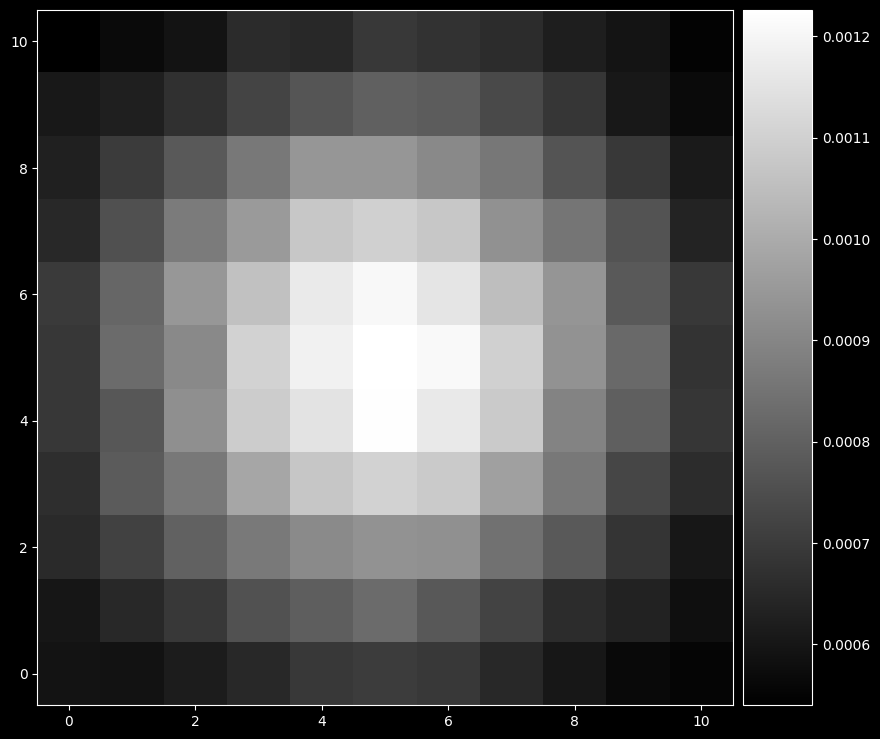

SHAPE:  (11, 11)
          c s
x compare 5 [5 5]
y compare 5 [5 5]
	shape : (11, 11)

	First cut

	hwhm 5
	hm_pos 10
	sigma 3.6067376022224087
	dim :  11 11
	cen :  5 5
	x :  0 11
	y :  0 11
	val0 0.0012261190303166432
	cen :  5 5
	shift [0 0]
	val1 0.0012261190303166432

sigma0 = 2.600855472391387
XERR None

Fit results:
	mode : curve_fit
	k: 7.319e-04 +/- 4e-06  -->  0.61 %	init : 0.00072
	sigma: 3.000e+00 +/- 2e-02  -->  0.50 %	init : 2.6
	x0: 4.956e+00 +/- 2e-02  -->  0.36 %	init : 5.0
	y0: 4.955e+00 +/- 2e-02  -->  0.38 %	init : 5.0
	corr_k-sigma	 = -0.74
	corr_k-x0	 = -0.041
	corr_k-y0	 = 0.045
	corr_sigma-x0	 = 0.012
	corr_sigma-y0	 = -0.075
	corr_x0-y0	 = -0.038

	Second cut

	hwhm 5
	hm_pos 10
	sigma 3.6067376022224087
	dim :  11 11
	cen :  5 5
	x :  0 11
	y :  0 11
	val0 0.0012261190303166432
	cen :  5 5
	shift [0 0]
	val1 0.0012261190303166432
cut_dim :  11 11
GOOD
xsize (41, 52)
ysize (34, 45)
[7.31921673e-04 3.00039138e+00 4.95533688e+00 4.95646012e+00] [4.45751012e-06 1.5

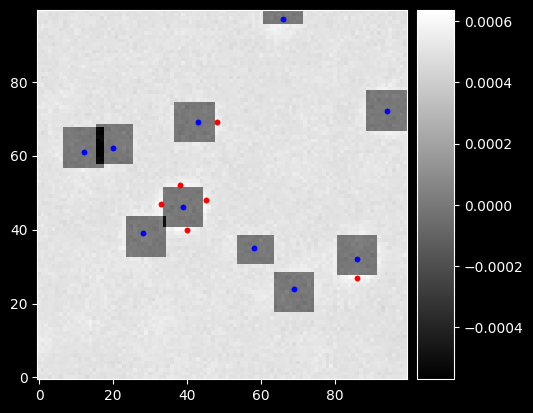

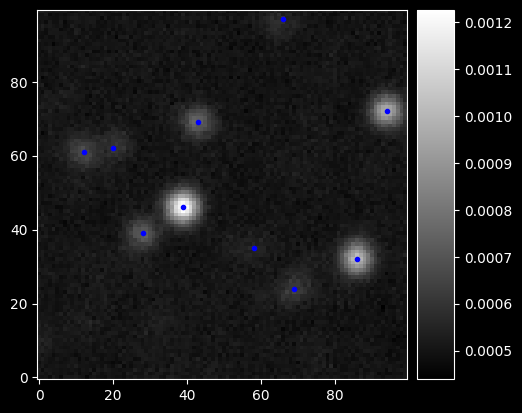


sigma0 = 2.600855472391387
XERR None

Fit results:
	mode : curve_fit
	k: 7.31921672663456580e-04 +/- 2e-20  -->  0.00 %	init : 0.00073
	sigma: 3.000391378574537526e+00 +/- 7e-17  -->  0.00 %	init : 2.6
	x0: 4.956460115946947020e+00 +/- 9e-17  -->  0.00 %	init : 5.0
	y0: 4.955336878556764191e+00 +/- 9e-17  -->  0.00 %	init : 5.0
	corr_k-sigma	 = -0.74
	corr_k-x0	 = 0.0029
	corr_k-y0	 = 0.0029
	corr_sigma-x0	 = -0.0053
	corr_sigma-y0	 = -0.0054
	corr_x0-y0	 = 2.8e-05

sigma0 = 2.600855472391387
XERR None

Fit results:
	mode : curve_fit
	k: 5.05245414103911621e-04 +/- 1e-20  -->  0.00 %	init : 0.00051
	sigma: 2.998856738378542719e+00 +/- 6e-17  -->  0.00 %	init : 2.6
	x0: 4.077613792856434216e+00 +/- 7e-17  -->  0.00 %	init : 4.0
	y0: 4.988074063682417680e+00 +/- 7e-17  -->  0.00 %	init : 5.0
	corr_k-sigma	 = -0.74
	corr_k-x0	 = 0.061
	corr_k-y0	 = 0.0008
	corr_sigma-x0	 = -0.12
	corr_sigma-y0	 = -0.0015
	corr_x0-y0	 = 0.00017

sigma0 = 2.600855472391387
XERR None

Fit results:
	mode : c

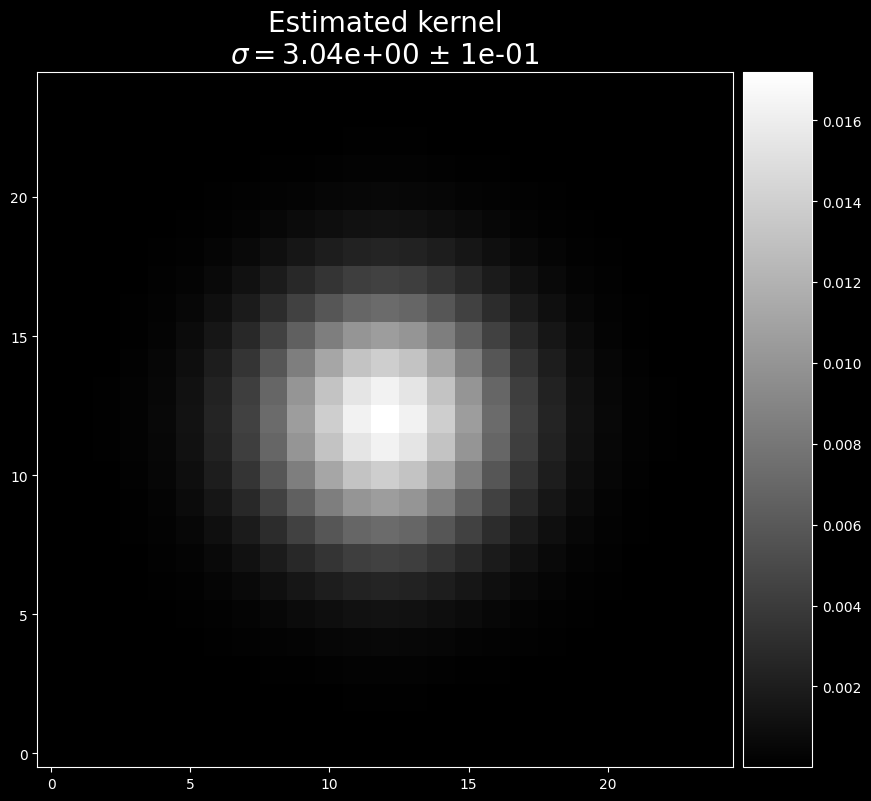

In [14]:

objs, errs, pos = searching(sci_frame, mean_bkg+Dmean_bkg, mean_bkg, errs=sigma, max_size=max_size, min_dist=2, num_objs=10, cntrl=20, cntrl_mode='bright', display_fig=False,log=True)

ker_sigma, ker_Dsigma = rst.kernel_estimation(objs, errs, m_bkg, display_plot=False,**kwargs)
kernel = stf.Gaussian(ker_sigma)


#### II method

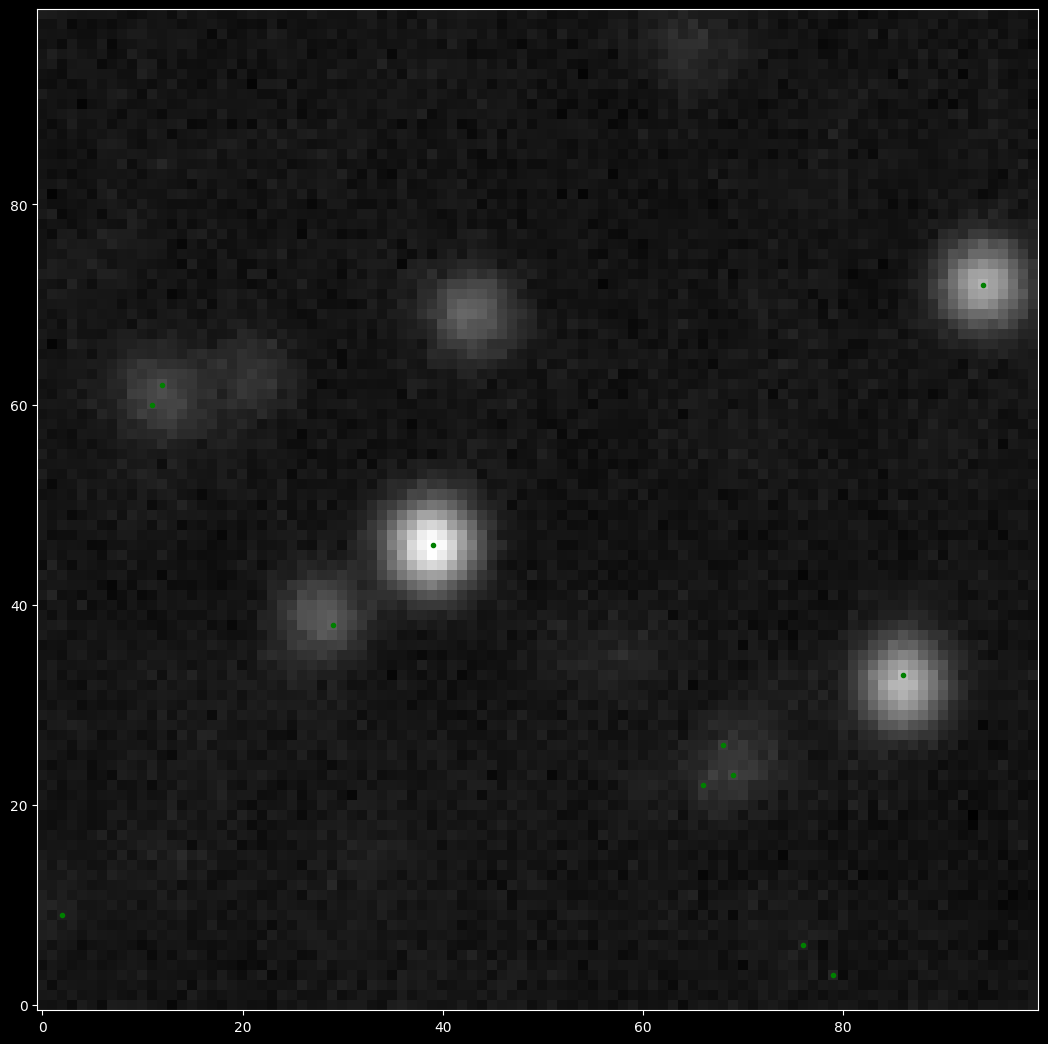

[0.00048677 0.00051651 0.00050815 0.00055858 0.00050216 0.00049837
 0.00050659 0.0005021  0.00051503 0.0005102  0.00050401 0.00048193]
[0.00048193 0.00048677 0.00049837 0.0005021  0.00050216 0.00050401
 0.00050659 0.00050815 0.0005102  0.00051503 0.00051651 0.00055858]
[ 3  1  8  9  2  6 10  4  7  5  0 11]


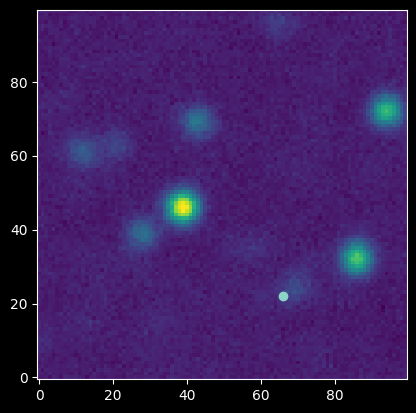

(22, 66)


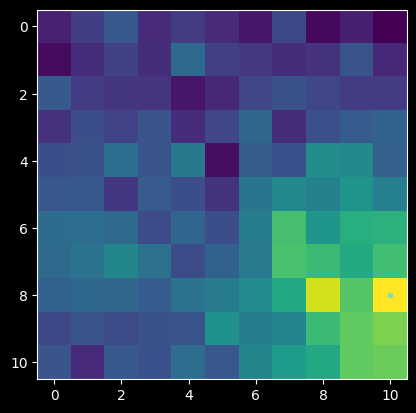

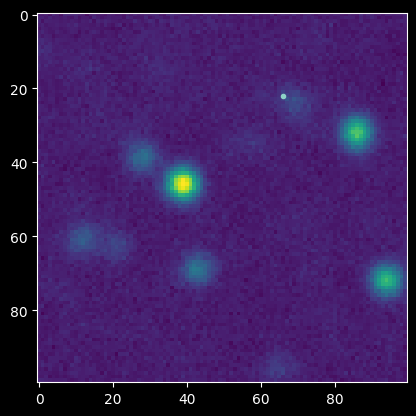

RuntimeError: No active exception to reraise

In [7]:
def find_maxima(data, display_plots: bool = False):
    xpos_max = np.argmax(data,axis=1)
    ypos_max = np.argmax(data,axis=0)
    pos_arr = np.arange(len(xpos_max))
    mat_xpos = [ (xpos_max[i],i) for i in pos_arr]
    mat_ypos = [ (i,ypos_max[i]) for i in pos_arr]
    match_pos = [ i in mat_ypos for i in mat_xpos]
    matches = np.array(mat_xpos)[match_pos].T
    if display_plots:
        plt.figure(figsize=(13,13))
        plt.imshow(data,cmap='gray',origin='lower')
        # plt.plot(xpos_max,pos_arr,'+',color='red')
        # plt.plot(pos_arr,ypos_max,'x',color='blue')
        plt.plot(*matches,'.g')
        plt.show()
    print(data[matches[0],matches[1]])
    print(np.sort(data[matches[0],matches[1]]))
    sort_pos = np.argsort(data[matches[0],matches[1]])[::-1]
    print(sort_pos)
    matches = matches[:,sort_pos]
    return matches

tmp_sci_frame = sci_frame.copy()
tmp_ind = find_maxima(sci_frame,True)
plt.figure()
plt.imshow(sci_frame,origin='lower')
plt.plot(*tuple(tmp_ind.T[0]),'o')
plt.show()
for tmpi in tmp_ind.T:
    tmpi = tuple(tmpi[::-1])
    print(tmpi)  
    tmp_xmax, tmp_ymax = tmpi
    if tmp_sci_frame[tmp_xmax,tmp_ymax] != 0.0:
        if tmp_sci_frame[tmp_xmax,tmp_ymax] <= mean_bkg+Dmean_bkg: 
            print(tmp_sci_frame[tmp_xmax,tmp_ymax])
            break
        xsize, ysize = rst.new_grad_check(tmp_sci_frame,tmpi,mean_bkg+Dmean_bkg,debug_check=False)
        # compute slices
        tmp_x = slice(tmp_xmax - xsize[0], tmp_xmax + xsize[1]+1)
        tmp_y = slice(tmp_ymax - ysize[0], tmp_ymax + ysize[1]+1)
        # define the object
        tmp_obj = sci_frame[tmp_x,tmp_y].copy()
        tmp_sci_frame[tmp_x,tmp_y] = 0.0
        # plt.figure()
        # plt.imshow(tmp_obj,cmap='gray',origin='lower')
        # plt.figure()
        # plt.imshow(tmp_sci_frame,cmap='gray',origin='lower')
        # plt.show()
tmp_ind = find_maxima(tmp_sci_frame,True)
for tmpi in tmp_ind.T:
    tmpi = tuple(tmpi[::-1])
    print(tmpi)  
    tmp_xmax, tmp_ymax = tmpi
    if tmp_sci_frame[tmp_xmax,tmp_ymax] != 0.0:
        if tmp_sci_frame[tmp_xmax,tmp_ymax] <= mean_bkg+Dmean_bkg: break
        xsize, ysize = rst.new_grad_check(tmp_sci_frame,tmpi,mean_bkg+Dmean_bkg,debug_check=False)
        # compute slices
        tmp_x = slice(tmp_xmax - xsize[0], tmp_xmax + xsize[1]+1)
        tmp_y = slice(tmp_ymax - ysize[0], tmp_ymax + ysize[1]+1)
        # define the object
        tmp_obj = sci_frame[tmp_x,tmp_y].copy()
        tmp_sci_frame[tmp_x,tmp_y] = 0.0
tmp_ind = find_maxima(tmp_sci_frame,True)
for tmpi in tmp_ind.T:
    tmpi = tuple(tmpi[::-1])
    print(tmpi)  
    tmp_xmax, tmp_ymax = tmpi
    if tmp_sci_frame[tmp_xmax,tmp_ymax] != 0.0:
        if tmp_sci_frame[tmp_xmax,tmp_ymax] <= mean_bkg+Dmean_bkg: break
        xsize, ysize = rst.new_grad_check(tmp_sci_frame,tmpi,mean_bkg+Dmean_bkg,debug_check=False)
        # compute slices
        tmp_x = slice(tmp_xmax - xsize[0], tmp_xmax + xsize[1]+1)
        tmp_y = slice(tmp_ymax - ysize[0], tmp_ymax + ysize[1]+1)
        # define the object
        tmp_obj = sci_frame[tmp_x,tmp_y].copy()
        tmp_sci_frame[tmp_x,tmp_y] = 0.0
tmp_ind = find_maxima(tmp_sci_frame,True)
for tmpi in tmp_ind.T:
    tmpi = tuple(tmpi[::-1])
    print(tmpi)  
    tmp_xmax, tmp_ymax = tmpi
    if tmp_sci_frame[tmp_xmax,tmp_ymax] != 0.0:
        if tmp_sci_frame[tmp_xmax,tmp_ymax] <= mean_bkg+Dmean_bkg: break
        xsize, ysize = rst.new_grad_check(tmp_sci_frame,tmpi,mean_bkg+Dmean_bkg,debug_check=False)
        # compute slices
        tmp_x = slice(tmp_xmax - xsize[0], tmp_xmax + xsize[1]+1)
        tmp_y = slice(tmp_ymax - ysize[0], tmp_ymax + ysize[1]+1)
        # define the object
        tmp_obj = sci_frame[tmp_x,tmp_y].copy()
        tmp_sci_frame[tmp_x,tmp_y] = 0.0
dpl.fast_image(tmp_sci_frame)


#### I method

In [ ]:
Dmean_bkg = sigma_bkg
trial = sci_frame - mean_bkg
# extract objects for the kernel recovery
objs, errs, pos = rst.searching(sci_frame, mean_bkg+Dmean_bkg, sigma, max_size=max_size, min_dist=2, display_fig=False,**kwargs)
# objs, errs, pos = rst.searching(trial, Dmean_bkg, sigma, max_size=max_size, min_dist=2, display_fig=False,**kwargs)
obj0 = np.copy(objs[0])
# estimate kernel
ker_sigma, ker_Dsigma = rst.kernel_estimation(objs[:6], errs[:6], m_bkg, display_plot=False,**kwargs)
# ker_sigma, ker_Dsigma = rst.kernel_estimation(objs[:6], errs[:6], (0,Dmean_bkg), display_plot=False,**kwargs)
# compute the estimated kernel
kernel = stf.Gaussian(ker_sigma)


In [ ]:

prb_obj = obj0
prb_x, prb_y = pos[:,0]
avg_cen = np.where(prb_obj == sci_frame[prb_x,prb_y])
avg_dist, avg_obj = rst.average_trend(prb_obj,avg_cen)
avg_obj -= mean_bkg
plt.figure()
plt.plot(avg_dist,avg_obj,'.--')

def gauss_func(x,*args):
    k,mu,sigma = args
    z = (x-mu)/sigma
    return k * np.exp(-z**2/2)
from scipy.optimize import curve_fit
avgmax = np.argmax(avg_obj)
hm = avg_obj[avgmax]/2
hm_pos = np.argmin(abs(hm-avg_obj))
hwhm = abs(avg_dist[avgmax]-avg_dist[hm_pos])
initial_values = [2*hm,0,ker_sigma]
pop, pcov = curve_fit(gauss_func,avg_dist,avg_obj,initial_values)
print(pop,np.sqrt(pcov.diagonal()))
xx = np.linspace(0,avg_dist.max(),100)
plt.plot(xx,gauss_func(xx,*pop))
plt.plot(xx,gauss_func(xx,*initial_values))

xdim, ydim = prb_obj.shape
yrange, xrange = np.meshgrid(np.arange(xdim),np.arange(ydim))
zeta = np.sqrt((xrange-avg_cen[0])**2+(yrange-avg_cen[1])**2)/pop[-1]
rec_obj = np.exp(-zeta**2/2)
rec_obj = pop[0]*rec_obj+mean_bkg
print(prb_obj[avg_cen])
print(rec_obj[avg_cen])
plt.figure()
plt.imshow(prb_obj)
plt.figure()
plt.imshow(rec_obj)
plt.figure()
plt.imshow(prb_obj-rec_obj)
plt.show()


### R-L

Dn 3.3777894535859476e-06
Dn 2.854200872827644e-07
Dn 6.509837449629291e-07
3223: - diff 6.510e-07	chisq 1.619e-09
Time: 159.41532063484192 s



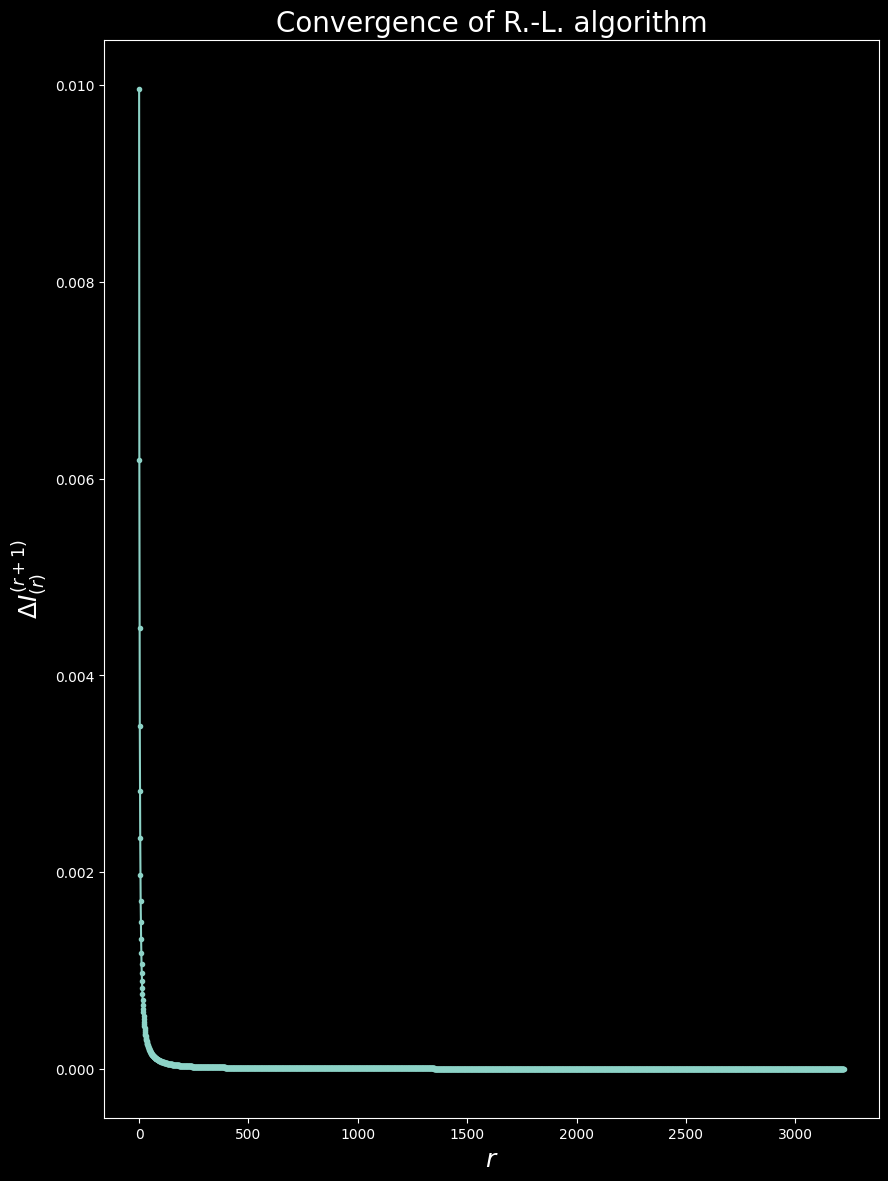

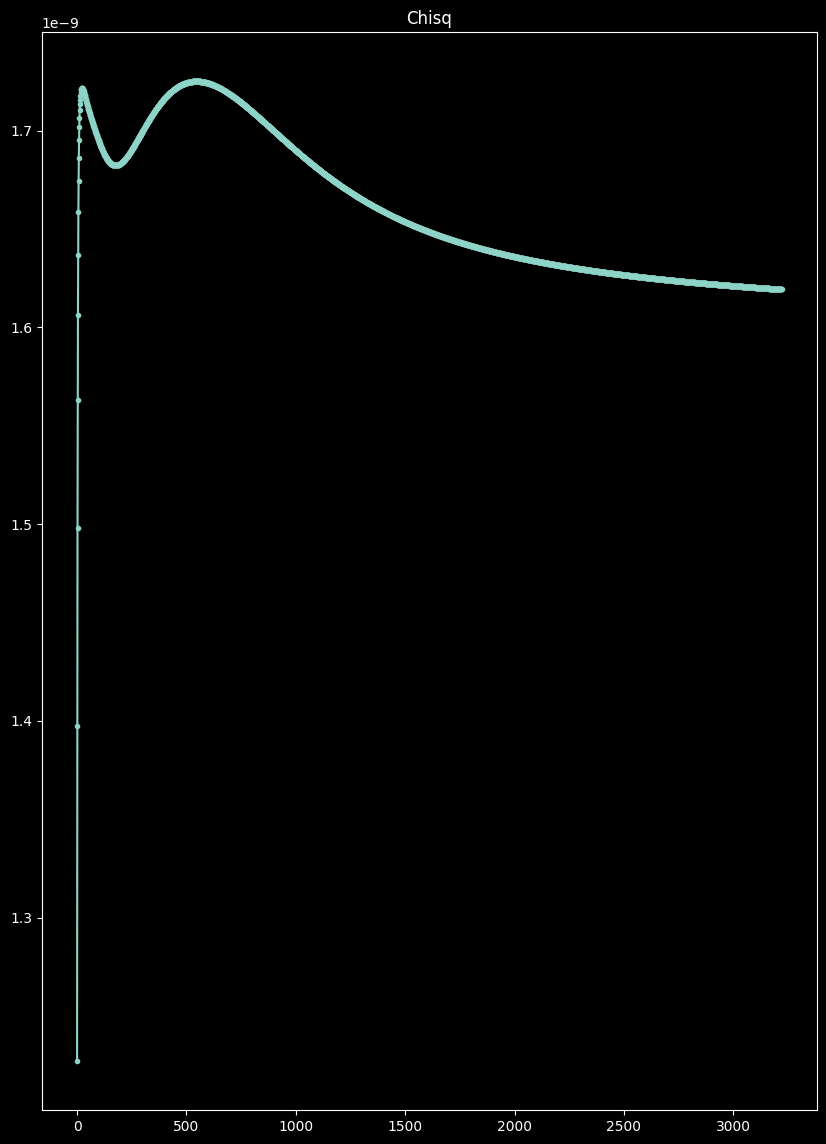

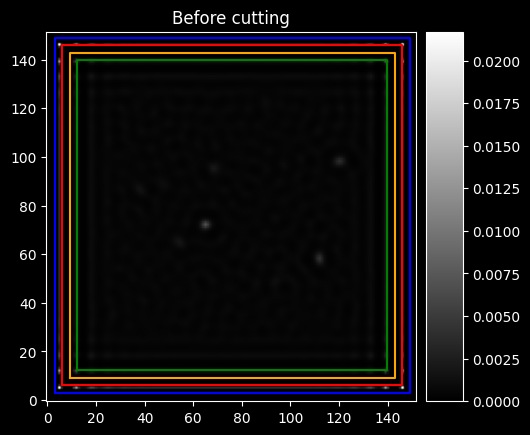

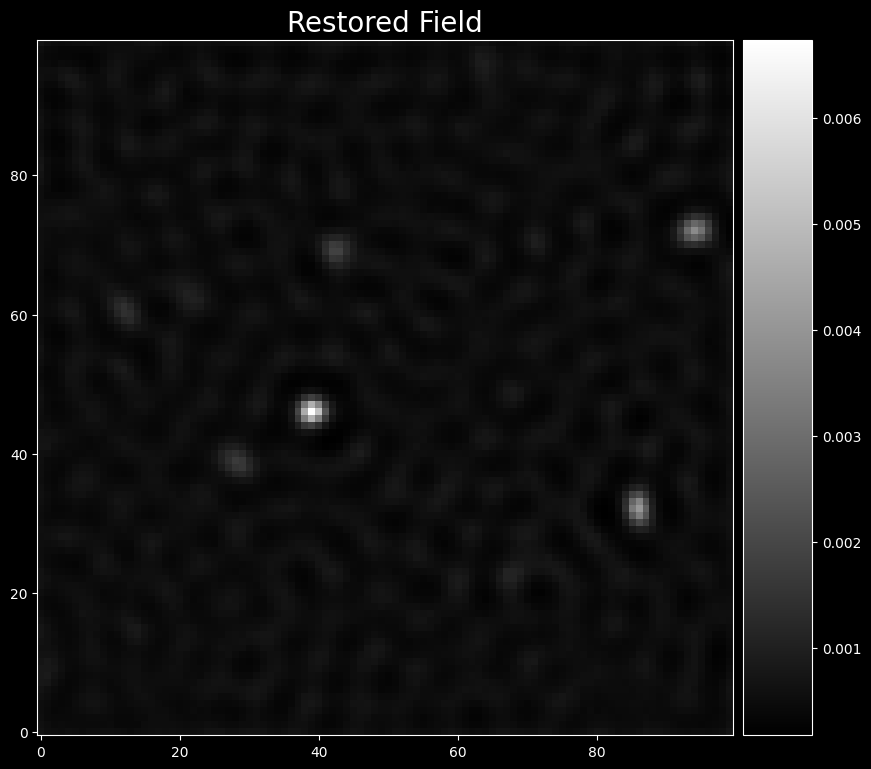

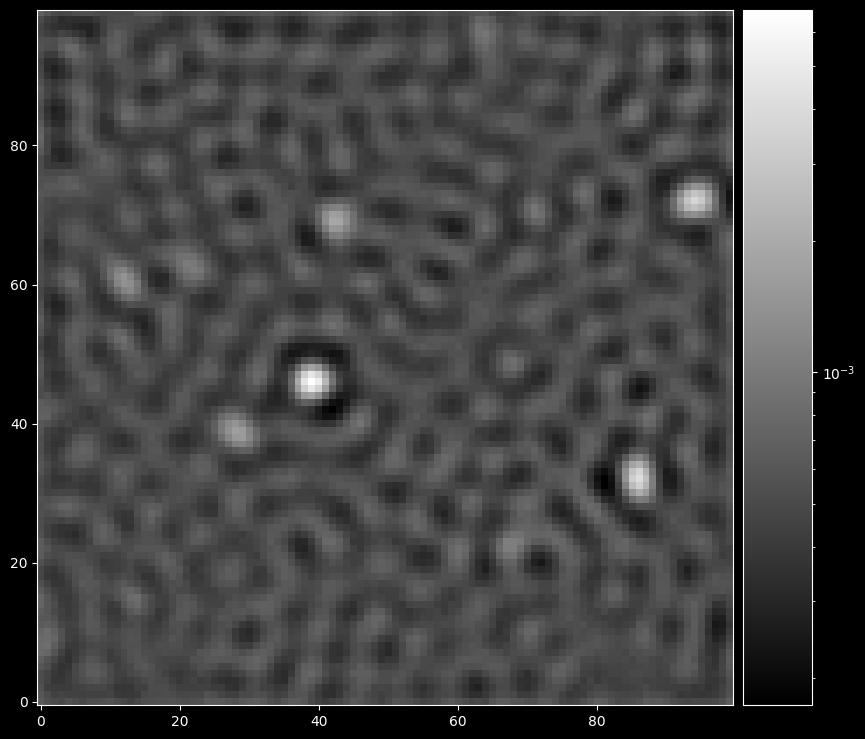

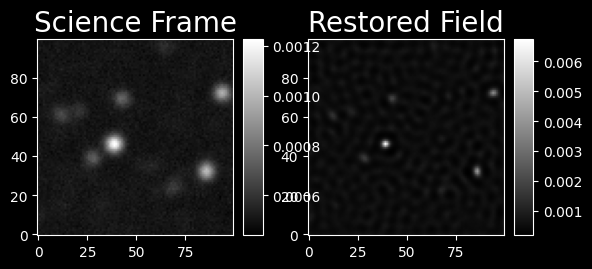

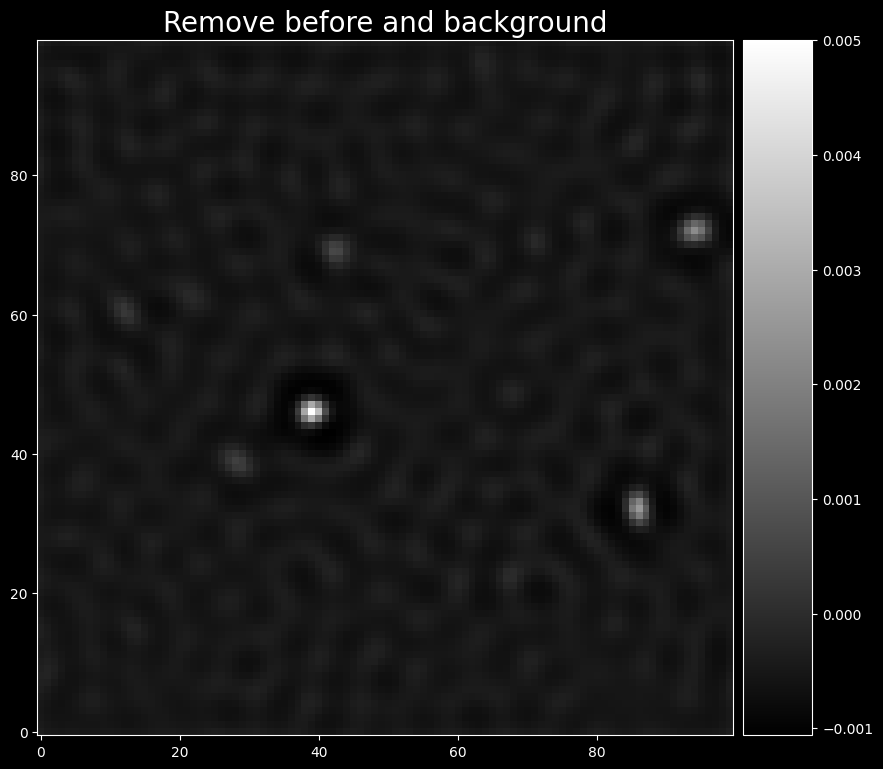

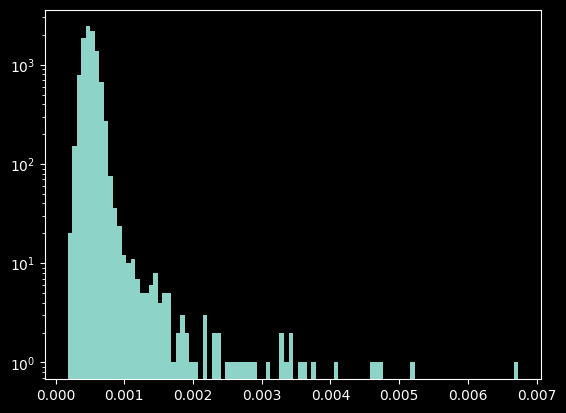

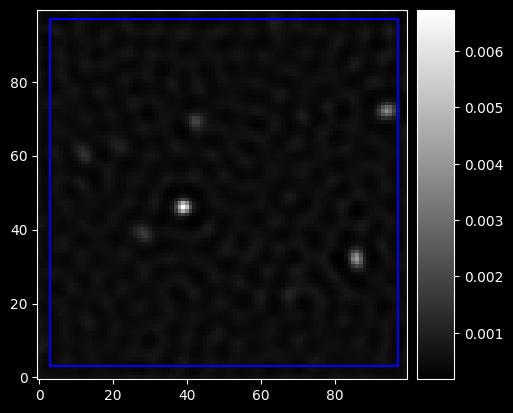

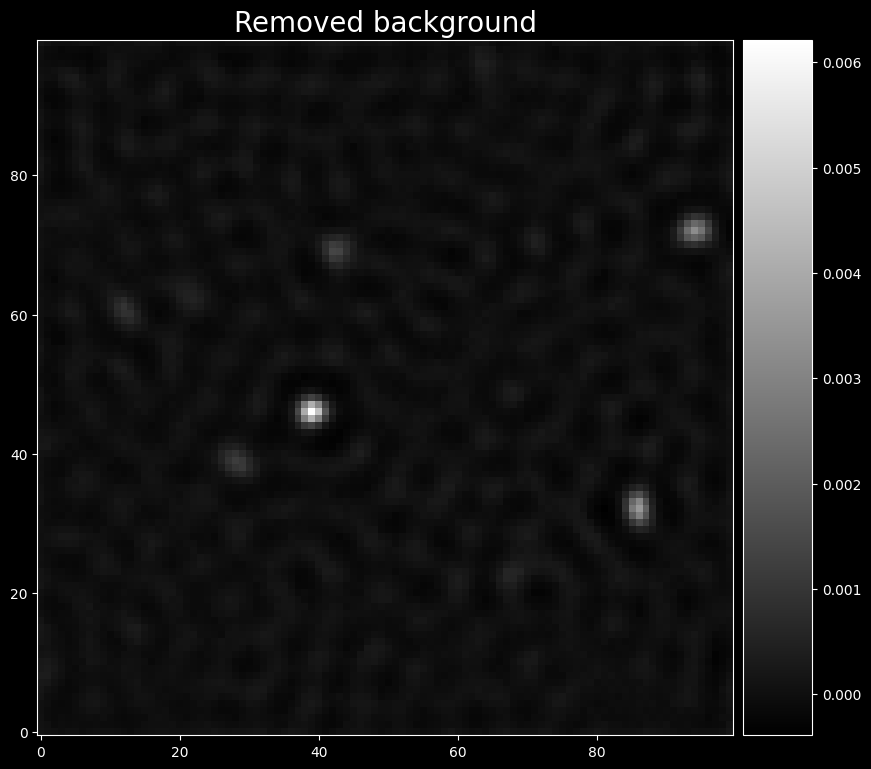

In [15]:
thr_mul = 1/sci_frame.sum()
# thr_mul = 1/mean_bkg
# mode = {'fillvalue': 0}
# mode = {'boundary': 'symm'}
mode = None
rec_field = rst.LR_deconvolution(sci_frame,kernel,sigma, mean_bkg, sigma_bkg,mode=mode,thr_mul=thr_mul, display_fig=True)
dpl.fast_image(rec_field - sci_frame - mean_bkg,'Remove before and background')
flat_field = rec_field.flatten()
plt.figure()
plt.hist(flat_field,100)
plt.yscale('log')

fig, ax = plt.subplots(1,1)
dim = len(rec_field)
dpl.field_image(fig, ax, rec_field)
mask0 = sqr_mask(ker_sigma, dim)
ax.plot(mask0[:,0], mask0[:,1], color='blue')
plt.show()

last_sen += [f'L2: {rec_field.max()*np.sqrt(18*np.pi)}']
art_bkg = stf.Gaussian(sigma_bkg, mean_bkg).field(rec_field.shape)
dpl.fast_image(rec_field - art_bkg, 'Removed background')



## Find Stars

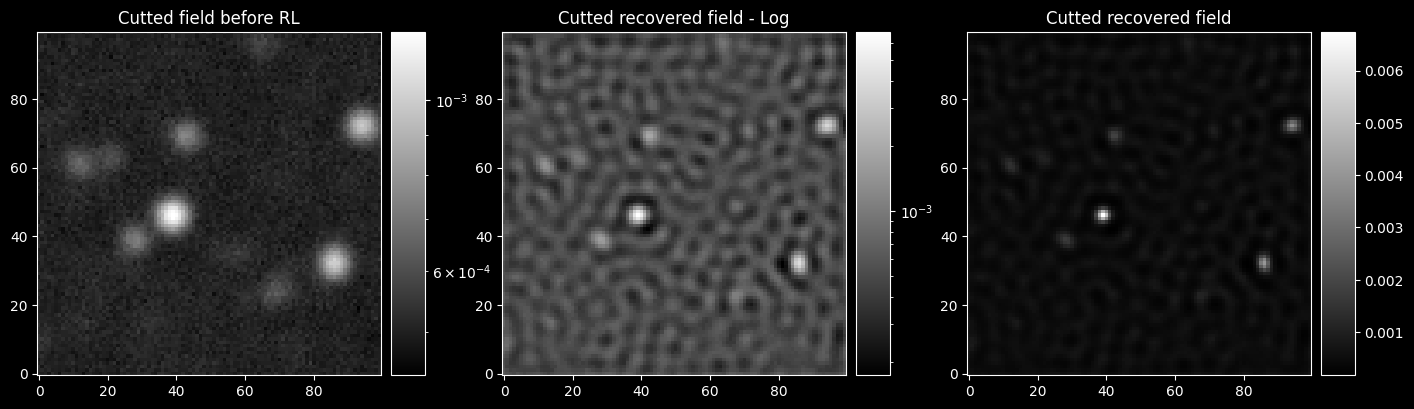

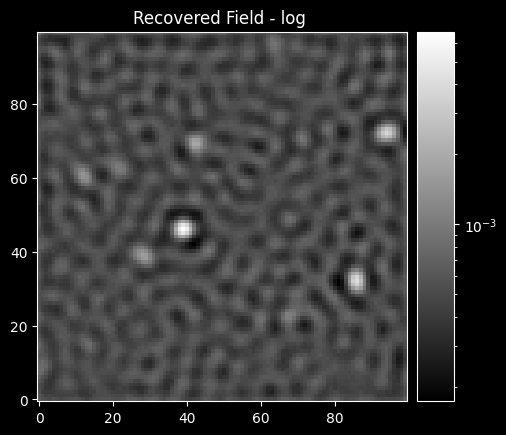


- - - SEARCHING START - - -
Stop_val : 0.000526273208984877

- - - -
Step 1
	coor : (46, 39)
	peak : 0.0067364054704222905
SHAPE:  (9, 9)
          c s
x compare 4 [4 4]
y compare 4 [4 4]
	shape : (9, 9)
LOW
0 9
0 9

	hwhm 5
	sigma 3.6067376022224087
	dim :  9 9
	cen :  4 4
	x :  0 9
	y :  0 9

sigma0 = 1.0201394465967897
XERR None

Fit results:
	mode : curve_fit
	k: 6.23e-03 +/- 1e-04  -->  1.94 %	init : 0.0062
	sigma: 1.162e+00 +/- 2e-02  -->  1.37 %	init : 1.0
	x0: 3.995e+00 +/- 2e-02  -->  0.57 %	init : 4.0
	y0: 4.068e+00 +/- 2e-02  -->  0.56 %	init : 4.0
	corr_k-sigma	 = -0.71
	corr_k-x0	 = -5.3e-06
	corr_k-y0	 = 6.4e-05
	corr_sigma-x0	 = 6.9e-06
	corr_sigma-y0	 = -8.4e-05
	corr_x0-y0	 = -1.4e-10
0 9
0 9
zero 4 4
shift [0 0]
zero 4 4
shape (9, 9)
xsize (42, 51)
ysize (35, 44)
[0.00622762 1.16246127 3.99459149 4.06759256] [0.00012099 0.01596606 0.02259084 0.02259076]
VARIANCE 0.00013808358965365956
CENVAL 0.0067364054704222905
CENVAL 0.00672418006155458
REC ERR [[0.00013808 0.0001

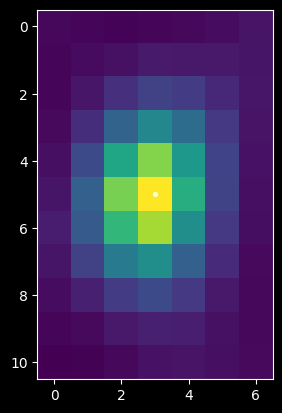

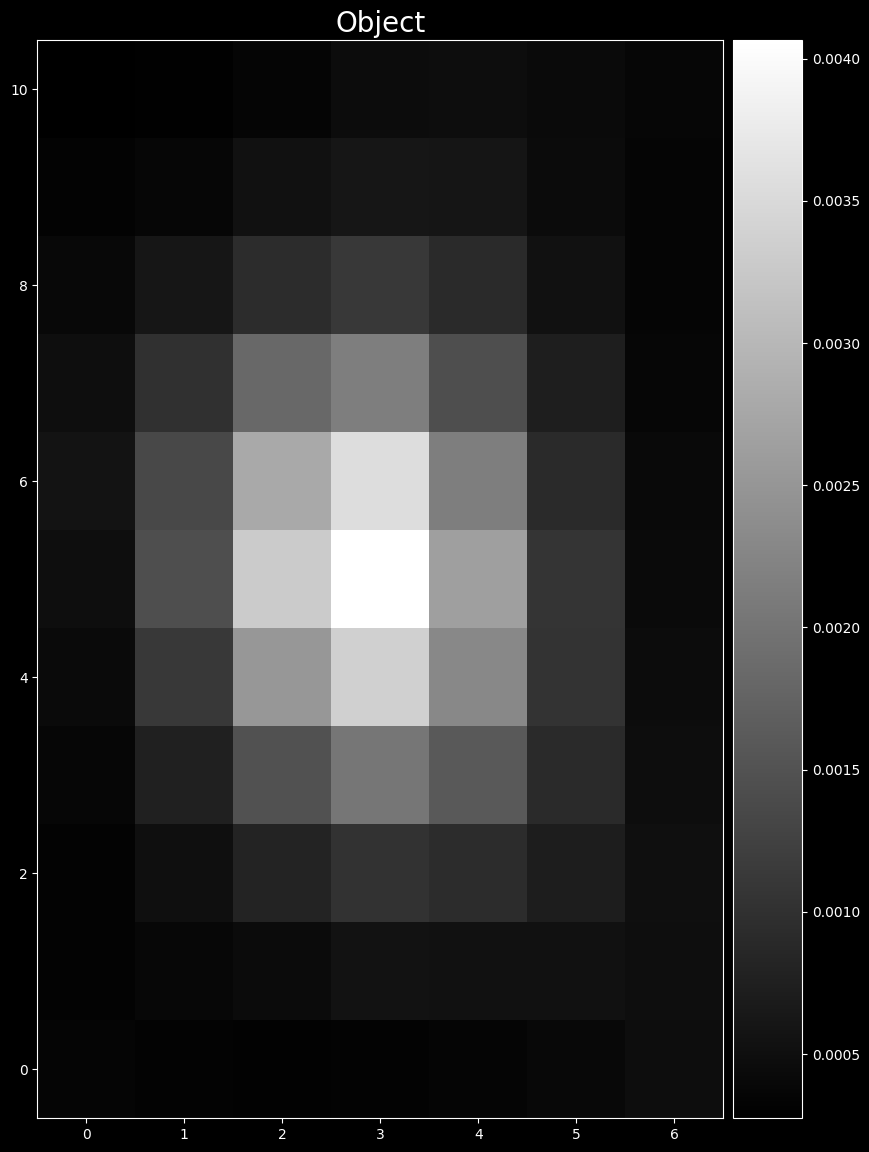

SHAPE:  (11, 7)
          c s
x compare 5 [5 5]
y compare 3 [3 3]


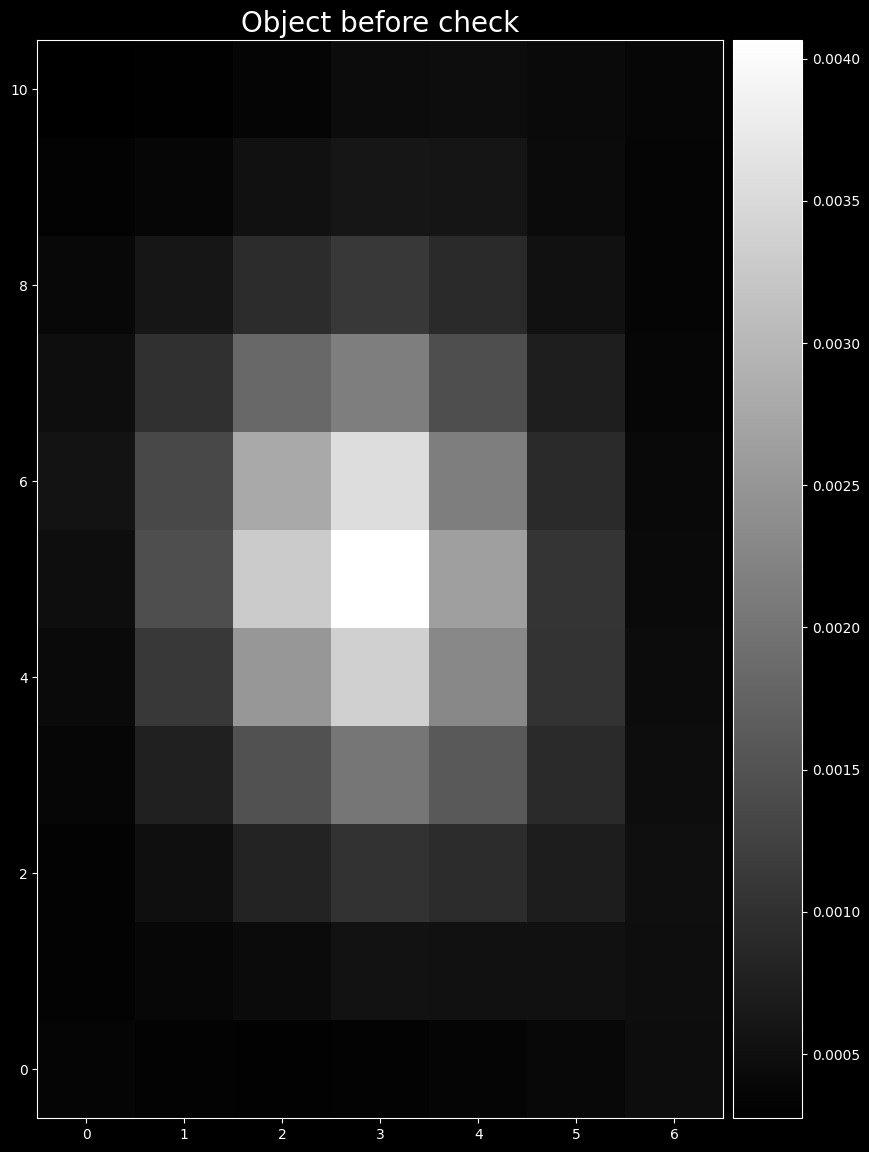

	shape : (11, 7)


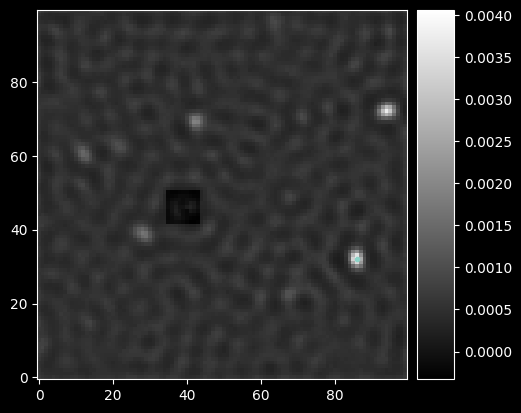

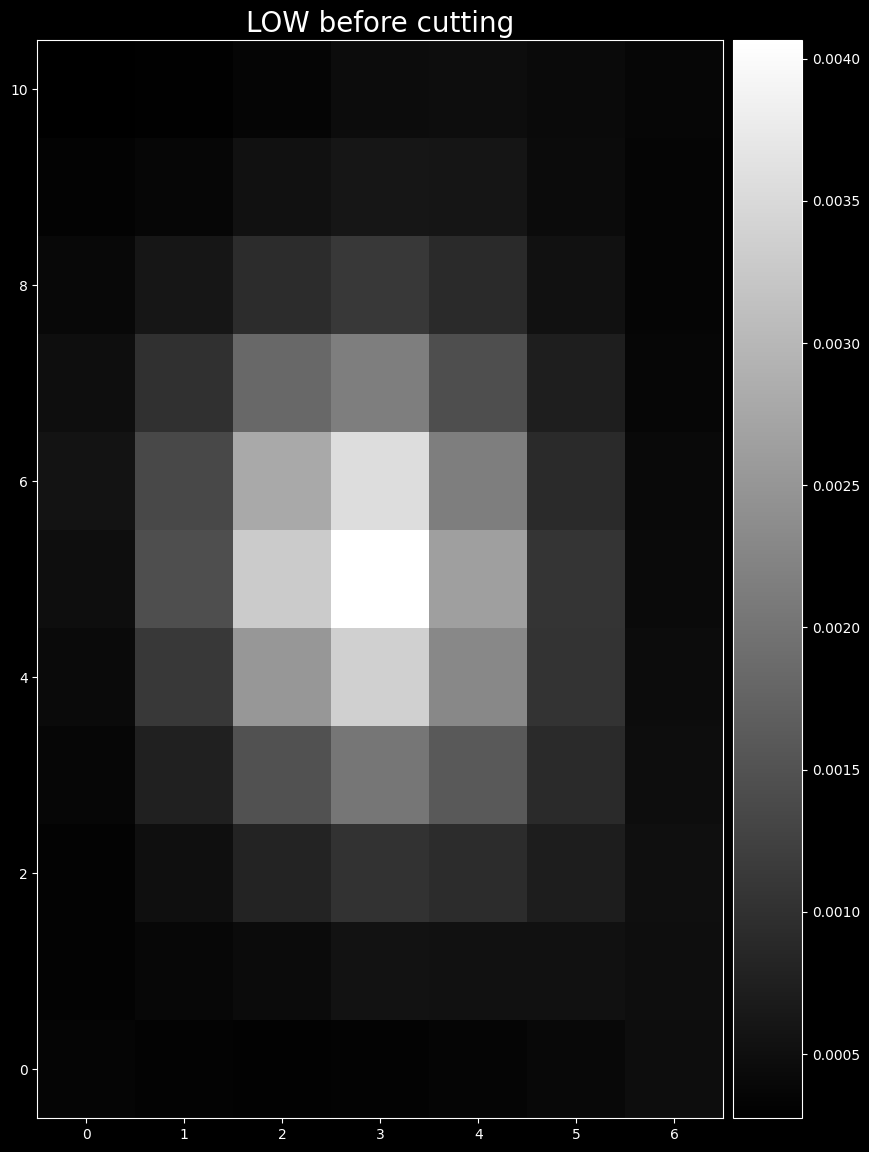

LOW
0 11
0 7


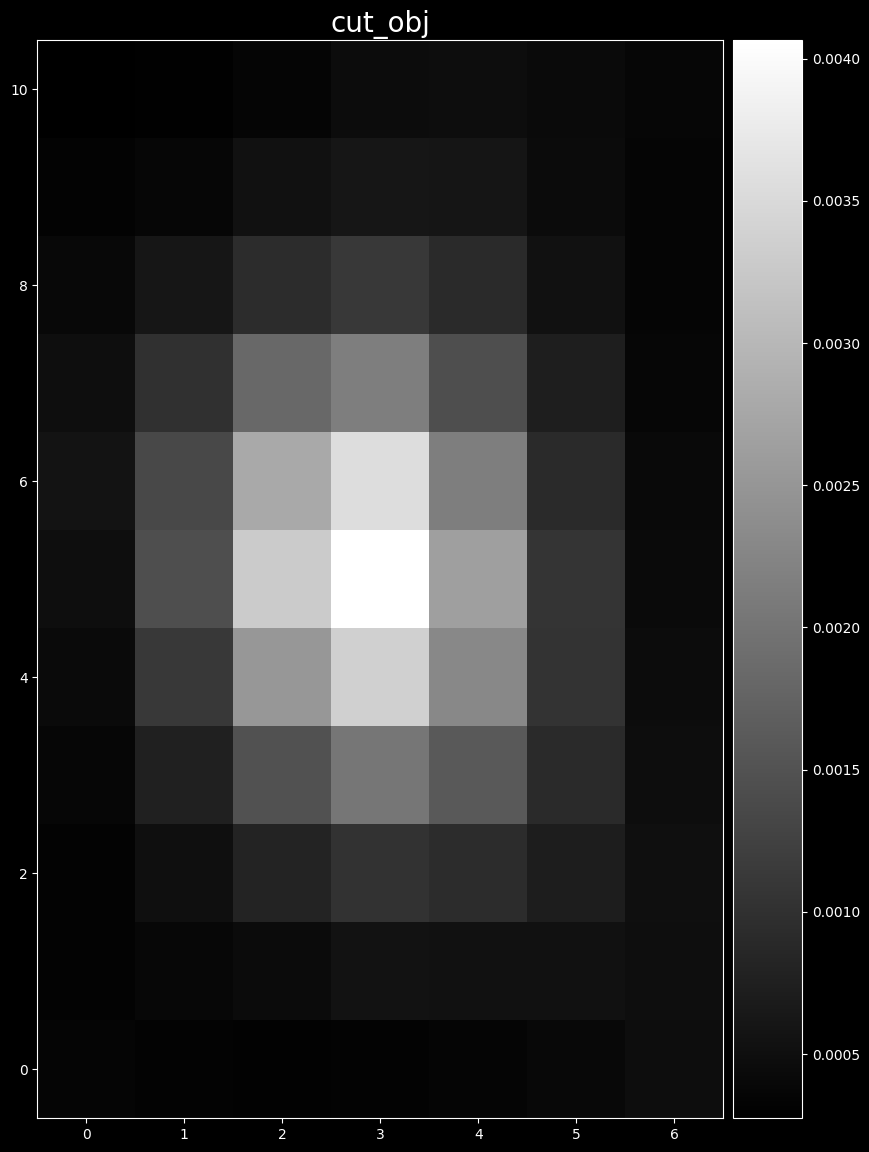


	hwhm 5
	sigma 3.6067376022224087
	dim :  11 7
	cen :  5 3
	x :  0 11
	y :  0 7

sigma0 = 1.0201394465967897
XERR None

Fit results:
	mode : curve_fit
	k: 3.63e-03 +/- 1e-04  -->  3.59 %	init : 0.0036
	sigma: 1.294e+00 +/- 3e-02  -->  2.55 %	init : 1.0
	x0: 5.062e+00 +/- 5e-02  -->  0.92 %	init : 5.0
	y0: 2.860e+00 +/- 5e-02  -->  1.62 %	init : 3.0
	corr_k-sigma	 = -0.71
	corr_k-x0	 = 3.4e-06
	corr_k-y0	 = 0.00088
	corr_sigma-x0	 = -4.5e-06
	corr_sigma-y0	 = -0.0014
	corr_x0-y0	 = 5.9e-09
0 11
0 7


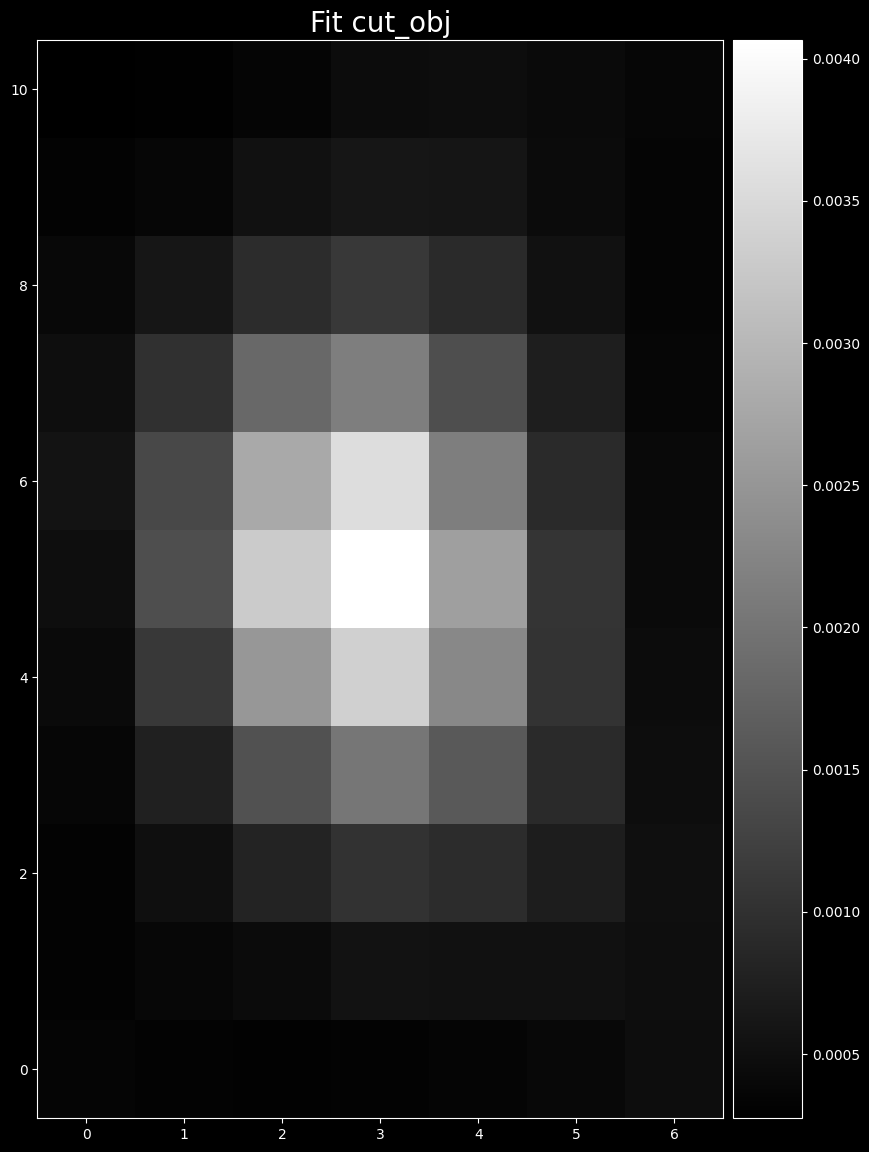

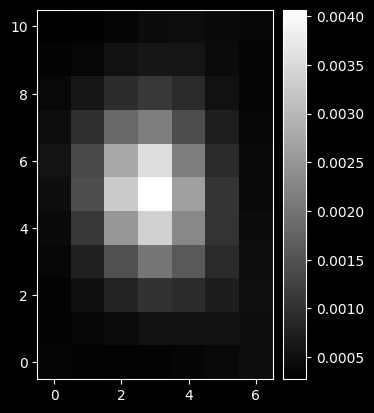

zero 5 3
shift [0 0]
zero 5 3
shape (11, 7)


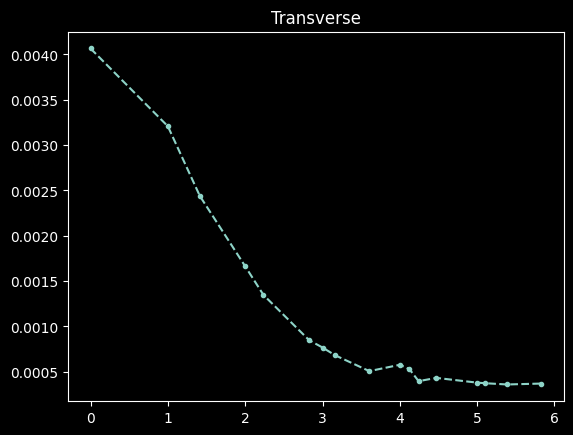

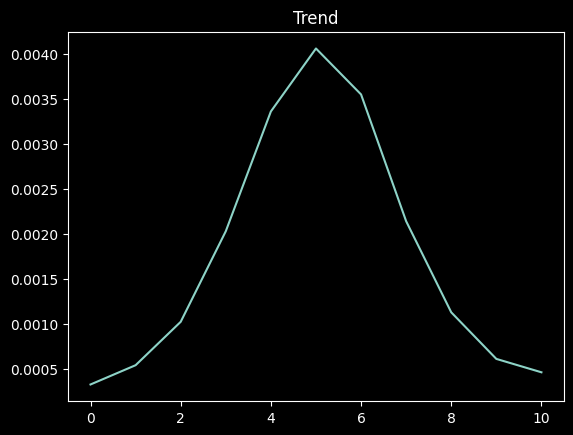

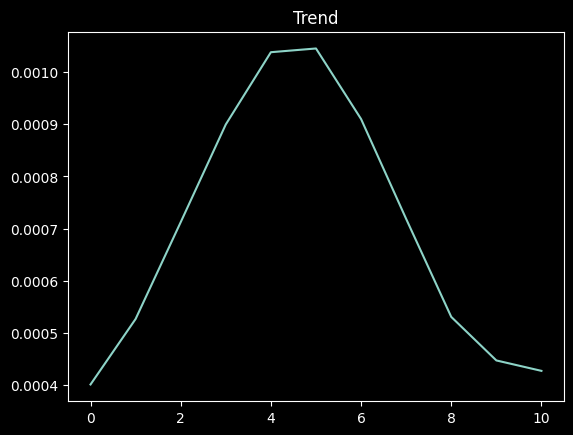

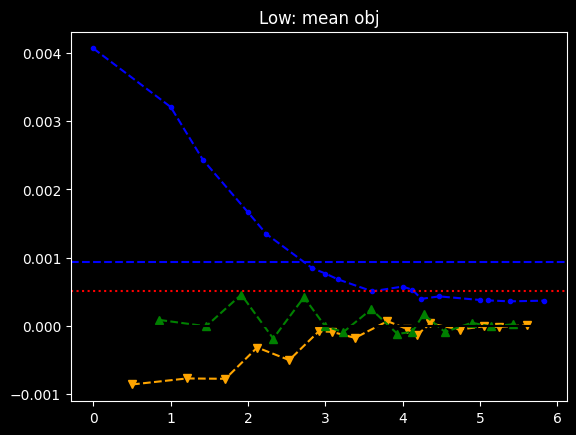

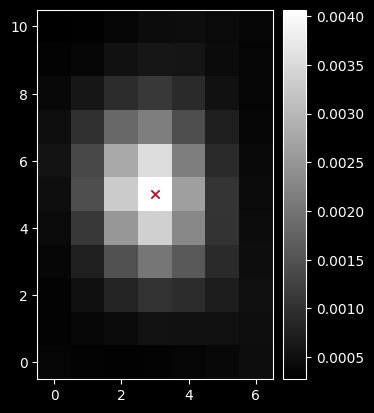

YO (27, 38) (83, 90)


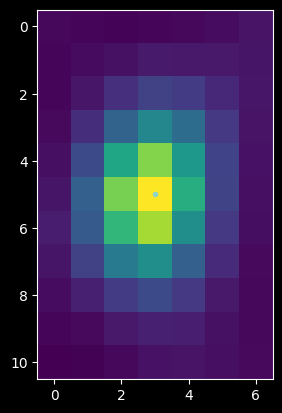

xsize (27, 38)
ysize (83, 90)


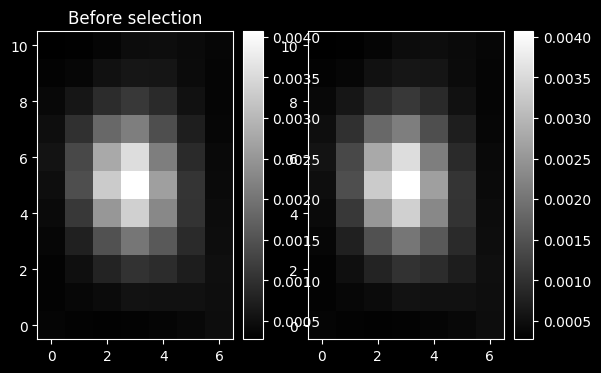

[3.62588766e-03 1.29376969e+00 5.06194224e+00 2.86033412e+00] [0.00013028 0.03292741 0.04643459 0.04646508]
VARIANCE 0.00020005600336465577
CENVAL 0.004064883413455685
CENVAL 0.004107842959104004
REC ERR [[0.00020006 0.00020006 0.00020006 0.00020006 0.00020006 0.00020006
  0.00020006]
 [0.00020006 0.00020006 0.00020006 0.00020006 0.00020006 0.00020006
  0.00020006]
 [0.00020006 0.00020006 0.00020006 0.00020006 0.00020006 0.00020006
  0.00020006]
 [0.00020006 0.00020006 0.00020006 0.00020006 0.00020006 0.00020006
  0.00020006]
 [0.00020006 0.00020006 0.00020006 0.00020006 0.00020006 0.00020006
  0.00020006]
 [0.00020006 0.00020006 0.00020006 0.00020006 0.00020006 0.00020006
  0.00020006]
 [0.00020006 0.00020006 0.00020006 0.00020006 0.00020006 0.00020006
  0.00020006]
 [0.00020006 0.00020006 0.00020006 0.00020006 0.00020006 0.00020006
  0.00020006]
 [0.00020006 0.00020006 0.00020006 0.00020006 0.00020006 0.00020006
  0.00020006]
 [0.00020006 0.00020006 0.00020006 0.00020006 0.00020006 0

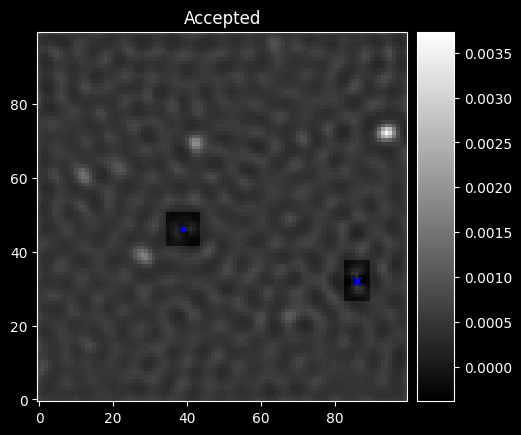


- - - -
Step 3
	coor : (72, 94)
	peak : 0.0037343961907840843


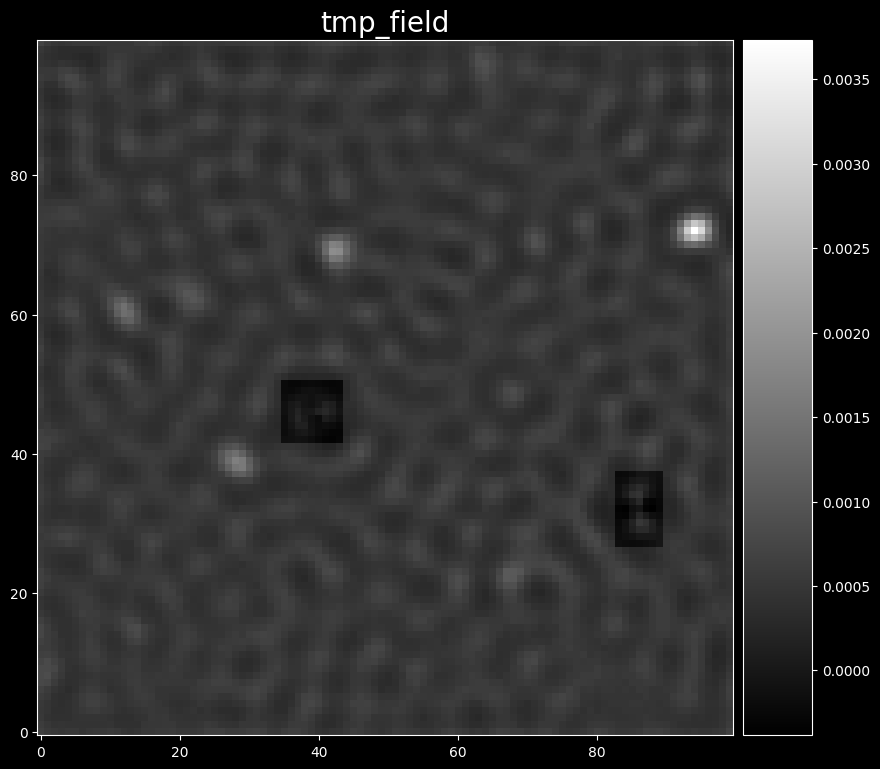

SHAPE:  (9, 9)
          c s
x compare 4 [4 4]
y compare 4 [4 4]
	shape : (9, 9)

	First cut

	hwhm 2
	hm_pos 6
	sigma 1.4426950408889634
	dim :  9 9
	cen :  4 4
	x :  2 7
	y :  2 7
	val0 0.0037343961907840843
	cen :  2 2
	shift [2 2]
	val1 0.0037343961907840843

sigma0 = 1.0201394465967897
XERR None

Fit results:
	mode : curve_fit
	k: 3.163e-03 +/- 9e-05  -->  2.73 %	init : 0.0032
	sigma: 1.362e+00 +/- 3e-02  -->  2.14 %	init : 1.0
	x0: 2.012e+00 +/- 4e-02  -->  1.82 %	init : 2.0
	y0: 2.113e+00 +/- 4e-02  -->  1.73 %	init : 2.0
	corr_k-sigma	 = -0.74
	corr_k-x0	 = -0.0017
	corr_k-y0	 = -0.016
	corr_sigma-x0	 = 0.0031
	corr_sigma-y0	 = 0.029
	corr_x0-y0	 = 8.8e-05

	Second cut

	hwhm 2
	hm_pos 6
	sigma 1.4426950408889634
	dim :  9 9
	cen :  4 4
	x :  2 7
	y :  2 7
	val0 0.0037343961907840843
	cen :  2 2
	shift [2 2]
	val1 0.0037343961907840843
cut_dim :  5 5
GOOD
xsize (68, 77)
ysize (90, 99)
[3.23067982e-03 1.32749053e+00 4.01091661e+00 4.11230741e+00] [8.17804935e-05 2.37634154e-02 3

/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minpack_py.py:881: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/home/bernardo/Scrivania/FISICA/ASTROFISICA/Astr_Oss/Progetti/proj_2/skysimulation/stuff.py:337: RuntimeWarning: invalid value encountered in cast
  order = np.floor(np.log10(number)).astype(int)
/home/bernardo/Scrivania/FISICA/ASTROFISICA/Astr_Oss/Progetti/proj_2/skysimulation/stuff.py:343: RuntimeWarning: overflow encountered in scalar subtract
  order = val_ord - err_ord + 1
/home/bernardo/Scrivania/FISICA/ASTROFISICA/Astr_Oss/Progetti/proj_2/skysimulation/restoration.py:284: RuntimeWarning: invalid value encountered in scalar divide
  corr = np.array([ cov[i,j]/np.sqrt(cov[i,i]*cov[j,j]) for i in range(cov.shape[0]) for j in range(i+1,cov.shape[1])])


          c s
x compare 5 [5 3]
y compare 3 [3 2]

sigma0 = 2.281101149119438
XERR None

Fit results:
	mode : curve_fit
	k: 1.28e-04 +/- 5e-05  -->  36.94 %	init : 0.00013
	sigma: 1.16e+00 +/- 3e-01  -->  28.09 %	init : 2.3
	x0: 4.19e+00 +/- 4e-01  -->  10.01 %	init : 4.0
	y0: 3.85e+00 +/- 4e-01  -->  11.61 %	init : 3.0
	corr_k-sigma	 = -0.72
	corr_k-x0	 = -0.00015
	corr_k-y0	 = -0.077
	corr_sigma-x0	 = 0.00028
	corr_sigma-y0	 = 0.15
	corr_x0-y0	 = 4.1e-05
Check is not good 2

- - - -
Step 177
	coor : (68, 34)
	peak : 0.0006348237686738867
SHAPE:  (8, 5)
          c s
x compare 0 [5 2]
y compare 4 [2 2]
row 0 7
[4 2]
x compare 0 [4 2]
y compare 4 [2 2]
row 0 6
[3 2]
x compare 0 [3 2]
y compare 4 [2 2]

sigma0 = 0.7213475204444817
XERR None

Fit results:
	mode : curve_fit
	k: 1.50e-04 +/- 3e-05  -->  22.64 %	init : 0.00013
	sigma: 1.08e+00 +/- 2e-01  -->  17.13 %	init : 0.72
	x0: 3.87e+00 +/- 3e-01  -->  6.50 %	init : 3.0
	y0: 1.96e+00 +/- 2e-01  -->  12.26 %	init : 2.0
	corr_k-sigma	 =

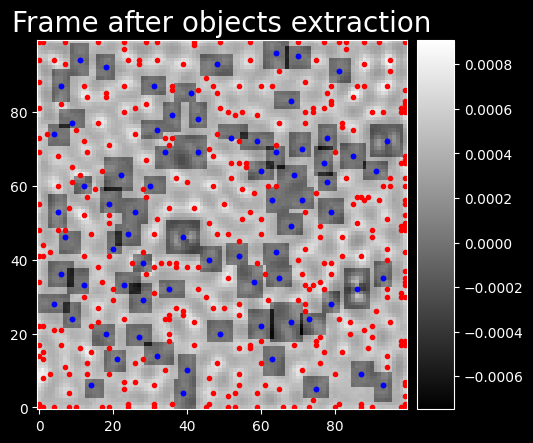

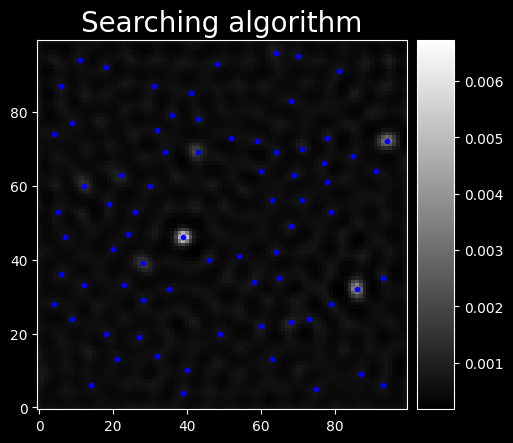

[array([[0.00013808, 0.00013808, 0.00013808, 0.00013808, 0.00013808,
        0.00013808, 0.00013808, 0.00013808, 0.00013808],
       [0.00013808, 0.00013808, 0.00013808, 0.00013808, 0.00013808,
        0.00013808, 0.00013808, 0.00013808, 0.00013808],
       [0.00013808, 0.00013808, 0.00013808, 0.00013808, 0.00013808,
        0.00013808, 0.00013808, 0.00013808, 0.00013808],
       [0.00013808, 0.00013808, 0.00013808, 0.00013808, 0.00013808,
        0.00013808, 0.00013808, 0.00013808, 0.00013808],
       [0.00013808, 0.00013808, 0.00013808, 0.00013808, 0.00013808,
        0.00013808, 0.00013808, 0.00013808, 0.00013808],
       [0.00013808, 0.00013808, 0.00013808, 0.00013808, 0.00013808,
        0.00013808, 0.00013808, 0.00013808, 0.00013808],
       [0.00013808, 0.00013808, 0.00013808, 0.00013808, 0.00013808,
        0.00013808, 0.00013808, 0.00013808, 0.00013808],
       [0.00013808, 0.00013808, 0.00013808, 0.00013808, 0.00013808,
        0.00013808, 0.00013808, 0.00013808, 0.00013808],

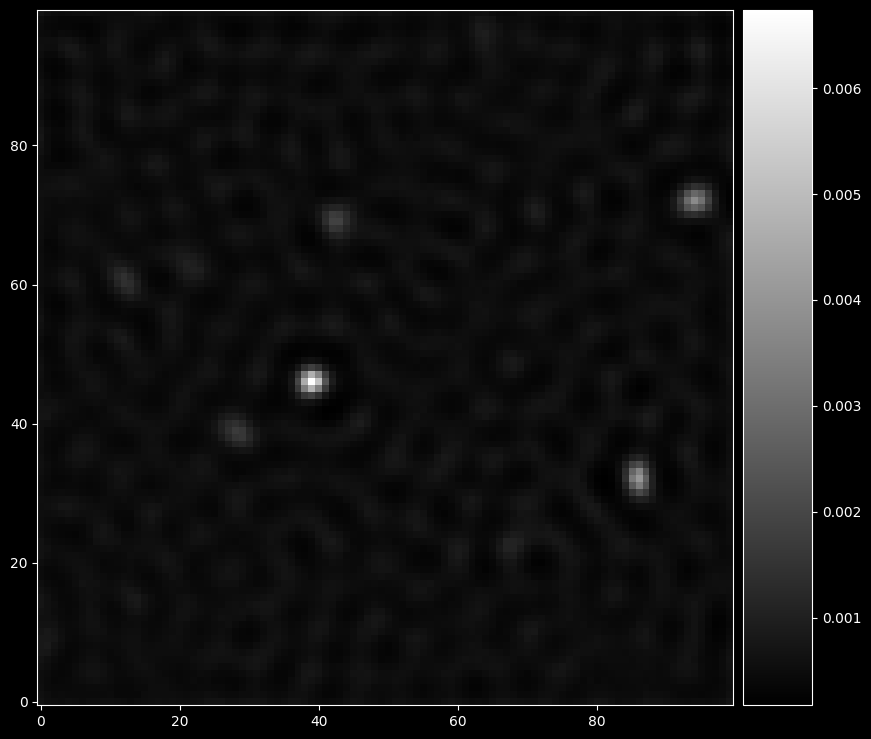

In [18]:
cut_slice = slice(None,None)
# cut_slice = slice(20,-19)
fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(17,19))
ax1.set_title('Cutted field before RL')
dpl.field_image(fig,ax1,sci_frame[cut_slice,cut_slice],norm='log')
fig, ax = plt.subplots(1,1)
ax.set_title('Recovered Field - log ')
dpl.field_image(fig,ax,rec_field,norm='log')
tmp_field = rec_field[cut_slice,cut_slice]
ax2.set_title('Cutted recovered field - Log')
dpl.field_image(fig,ax2,tmp_field,norm='log')
ax3.set_title('Cutted recovered field')
dpl.field_image(fig,ax3,tmp_field)
plt.show()
objs, err, obj_pos = rst.searching(tmp_field, mean_bkg+Dmean_bkg, mean_bkg, max_size=5, cntrl=None, cntrl_sel='bright', debug_plots=False,log='True')
# objs, err, pos = rst.searching(rec_field, mean_bkg*105e-100, sigma, max_size=5, cntrl=None, cntrl_sel='bright', debug_plots=False)
print(err)
dpl.fast_image(tmp_field)


6.558570689128542
33.43793525652801
48.274618718476034 47.43416490252569


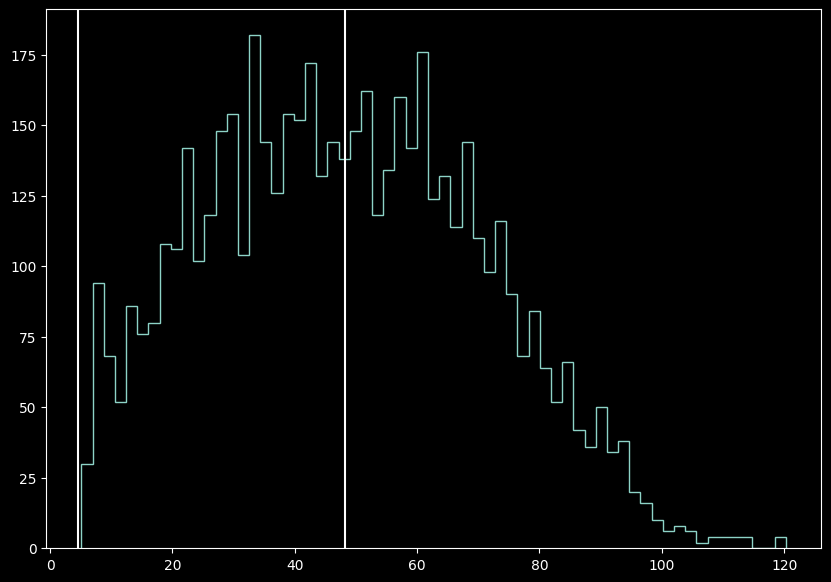

In [96]:
xpos, ypos = obj_pos
distances = np.array([ np.sqrt((xpos-x)**2 + (ypos-y)**2) for x,y in zip(xpos,ypos)]).flatten()
distances = distances[distances!=0]
print(len(sci_frame)/np.sqrt(len(objs)*np.pi))
plt.figure(figsize=(10,7))
cnts, bins, _ = plt.hist(distances,63,histtype='step')
print((bins[1:]+bins[:-1])[cnts.argmax()]/2)
plt.axvline(1.5*ker_sigma,0,1)
plt.axvline(np.mean(distances),0,1)
print(np.mean(distances), np.median(distances))
plt.show()


In [14]:
def compute_mode(counts: list[NDArray], binns: list[NDArray], a_dist: list[NDArray]) -> int:
    _, stars = fld.initialize(p_seed=None)
    sxpos, sypos = stars.pos
    dists = np.array([np.sqrt((sxpos - x)**2 + (sypos - y)**2) for x,y in zip(sxpos,sypos)]).flatten()
    dists = dists[dists!=0]
    cnts, bins = np.histogram(dists,60)
    a_dist += [dists]
    counts += [cnts]
    binns  += [bins]
    bindist = (bins[1:]+bins[:-1])/2
    # return bindist[cnts.argmax()]
    return np.mean(dists)

counts = []
binns  = []
a_dist = [] 

peaks = [ compute_mode(counts,binns,a_dist) for _ in range(3000) ]
a_dist = np.array([*a_dist]).flatten()


52.140092001621085 1.666918064568116


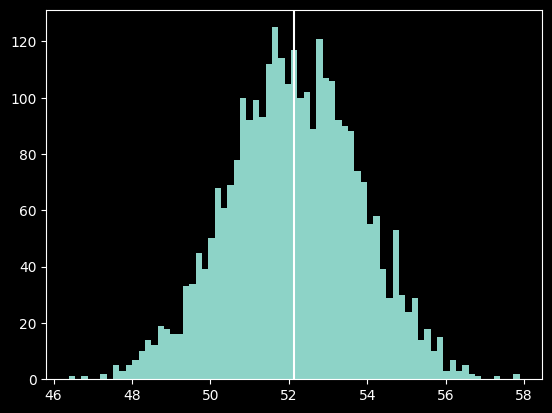

In [15]:
print(np.mean(peaks), np.std(peaks))
plt.figure()
plt.hist(peaks,71)
plt.axvline(np.mean(peaks),0,1)
plt.show()

52.140092001621056 24.79176388848157


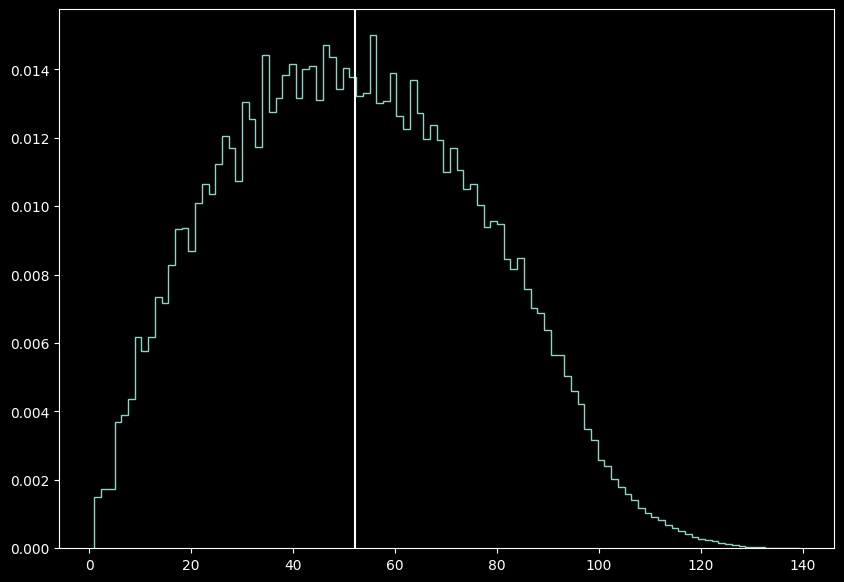

In [21]:
print(np.mean(a_dist), np.std(a_dist))
plt.figure(figsize=(10,7))
plt.hist(a_dist,105,density=True,histtype='step')
plt.axvline(np.mean(a_dist),0,1)
plt.show()

## Lum Recovery

$$ f(M) = M^{-\alpha} $$
$$ L = K\; M^{\beta} $$
$$ f(M)dM = f(L)dL $$
$$ f(L) = \frac{1}{\beta} \Bigl ( \frac{L}{K} \Bigr )^{(1-\alpha-\beta)/\beta} $$

0.004939383594304325
sigma 2

Luminosities:
L0: 0.041729342977631395
L0.5: 0.009574260849096444
L1: 0.009175341649778266
L2: 0.04064800464107549
L3: 0.024762397153463435 +/- 0.0022572405942865507
L4: 0.027307864033733937
NO - 7.52
VAL 0.5934049133420835 0.05409240676270706
VAL 0.5994739913192688
Mean Val: 0.0019201048094086588 0.001635027691089491


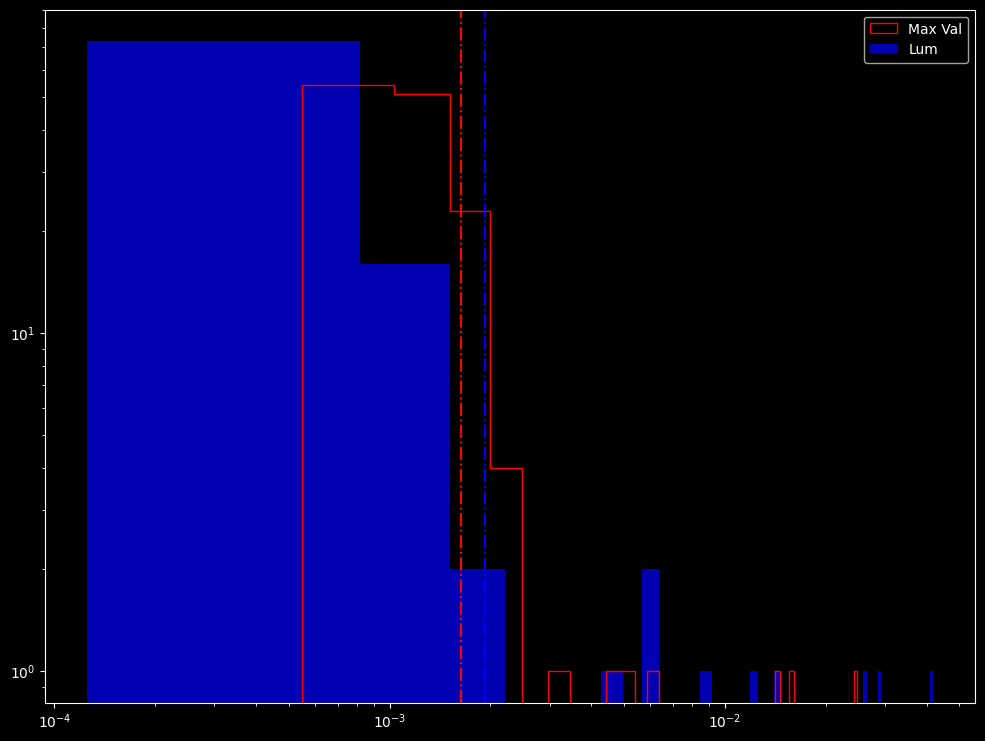



------

FOUND:	139
OBSER:	39


In [ ]:
Dmean_bkg = 0
print(objs[0].max()-mean_bkg)
lum = S.lum
# maxvalues  = np.array([ tmp_field[x,y] for x, y in zip(*obj_pos)])
maxvalues  = np.array([o.max()-mean_bkg for o in objs])
maxerr  = np.array([np.sqrt(err[i][stf.peak_pos(objs[i])]**2 + Dmean_bkg**2) for i in range(len(objs))])
val_obj0 = maxvalues.max()*np.sqrt(2*np.pi*ker_sigma**2)
err_obj0 = maxerr[maxvalues.argmax()]
err_obj0 = np.sqrt((err_obj0/maxvalues.max())**2 + (ker_Dsigma/ker_sigma)**2) * val_obj0
print('sigma',ker_sigma)
print('\nLuminosities:')
for sen in last_sen:
    print(sen)
print(f'L3: {maxvalues.max()*np.sqrt(2*np.pi*ker_sigma**2)} +/- {err_obj0}')
print(f'L4: {objs[0].max()*np.sqrt(2*np.pi*ker_sigma**2)}')
val = maxvalues.max()*np.sqrt(2*np.pi*ker_sigma**2)
print('OK' if val - err_obj0 <= lum.max() <= val + err_obj0 else 'NO', f'- {abs(val-lum.max())/err_obj0:.2f}')
print('VAL',maxvalues.max()*np.sqrt(2*np.pi*ker_sigma**2)/lum.max(),err_obj0/lum.max())
print('VAL',(maxvalues.max()+m_dark.mean())*np.sqrt(2*np.pi*ker_sigma**2)/lum.max())
maxvalues *= np.sqrt(2*np.pi*ker_sigma**2)
print('Mean Val:',lum.mean(),maxvalues.mean())
# from scipy.integrate import trapezoid
# maxvalues = np.array([ trapezoid(trapezoid(obj)) for obj in objs])
plt.figure(figsize=(12,9))
binnn = lambda arr : 10**(np.linspace(np.log10(arr).min(),np.log10(arr).max(),10))
plt.hist(maxvalues,50, histtype='step',color='red',label='Max Val')
plt.hist(lum,60, histtype='barstacked', label='Lum',color='blue',alpha=0.7)
plt.axvline(lum.mean(),0,1,linestyle='dashdot',color='blue')
plt.axvline(maxvalues.mean(),0,1,linestyle='dashdot',color='red')
# plt.xscale('log')
# plt.axvline(np.mean(maxvalues),0,1,linestyle='dashed',color='red')
# plt.axvline(np.mean(lum),0,1,linestyle='dashed',color='blue')
# plt.axvline(mean_bkg,0,1,linestyle='-.',color='violet',label='mean_bkg')
plt.yscale('log')
plt.xscale('log')
plt.legend()
plt.show()
print(f'\n\n------\n\nFOUND:\t{len(objs)}\nOBSER:\t{len(lum[lum>mean_bkg])}')


## Test

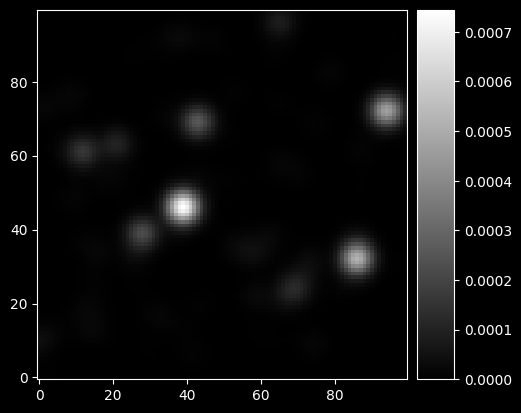

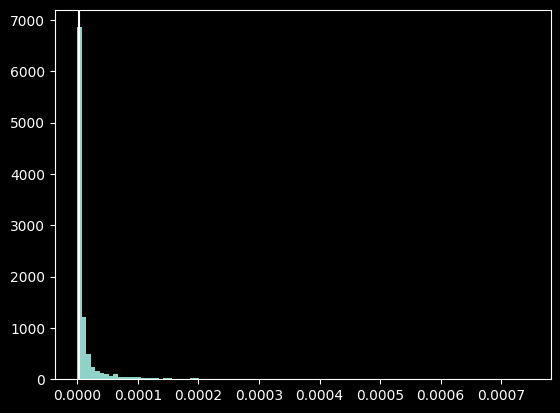


- - - SEARCHING START - - -
Stop_val : 3.0890715844089475e-06
[7 7] [7 7]


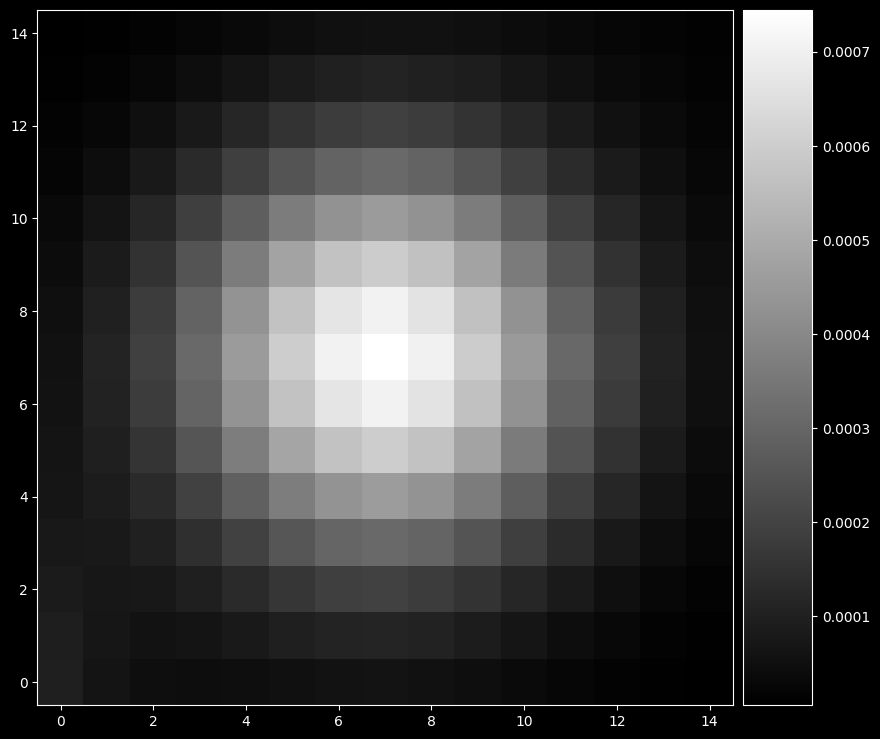


	hwhm 2
	hm_pos 5
	sigma 1.4426950408889634
	dim :  15 15
	cen :  7 7
	x :  5 10
	y :  5 10
	val0 0.0007446627024368144
	cen :  2 2
	shift [5 5]
	val1 0.0007446627024368144

sigma0 = 2.0402788931935794
XERR None

Fit results:
	mode : curve_fit
	k: 7.4151e-04 +/- 1.5e-07  -->  0.02 %	init : 0.00074
	sigma: 3.0081e+00 +/- 1.4e-03  -->  0.05 %	init : 2.0
	x0: 1.99364e+00 +/- 7.9e-04  -->  0.04 %	init : 2.0
	y0: 1.98709e+00 +/- 7.9e-04  -->  0.04 %	init : 2.0
	corr_k-sigma	 = -0.83
	corr_k-x0	 = 0.0033
	corr_k-y0	 = 0.0068
	corr_sigma-x0	 = -0.0061
	corr_sigma-y0	 = -0.012
	corr_x0-y0	 = 7.5e-05

	hwhm 2
	hm_pos 5
	sigma 1.4426950408889634
	dim :  15 15
	cen :  7 7
	x :  5 10
	y :  5 10
	val0 0.0007446627024368144
	cen :  2 2
	shift [5 5]
	val1 0.0007446627024368144
[7.35313076e-04 3.04356767e+00 6.97204526e+00 6.97362701e+00] [3.43492371e-06 1.01860198e-02 1.41563188e-02 1.41563149e-02]
VARIANCE 1.2660102338629129e-05
CENVAL 0.0007446627024368144
CENVAL 0.0007383435283426861

	hwhm 3
	hm

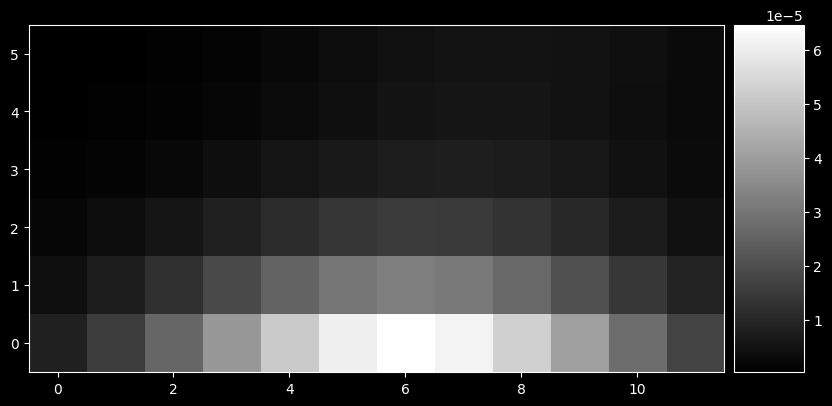

Check -1

	hwhm 6
	hm_pos 13
	sigma 4.328085122666891
	dim :  15 15
	cen :  7 7
	x :  1 14
	y :  1 14
	val0 4.6003608565992995e-05
	cen :  6 6
	shift [1 1]
	val1 4.6003608565992995e-05

sigma0 = 2.600855472391387
XERR None

Fit results:
	mode : curve_fit
	k: 4.219e-05 +/- 9.1e-07  -->  2.17 %	init : 4.3e-05
	sigma: 3.677e+00 +/- 6.6e-02  -->  1.79 %	init : 2.6
	x0: 6.702e+00 +/- 8.0e-02  -->  1.19 %	init : 6.0
	y0: 6.577e+00 +/- 7.9e-02  -->  1.21 %	init : 6.0
	corr_k-sigma	 = -0.74
	corr_k-x0	 = -0.044
	corr_k-y0	 = -0.037
	corr_sigma-x0	 = 0.083
	corr_sigma-y0	 = 0.068
	corr_x0-y0	 = 0.0056

	hwhm 3
	hm_pos 11
	sigma 2.1640425613334453
	dim :  15 15
	cen :  8 8
	x :  5 12
	y :  5 12
	val0 4.5040968822985963e-05
	cen :  3 3
	shift [5 5]
	val1 4.5040968822985963e-05
[4.15976352e-05 3.74439296e+00 7.67088648e+00 7.69033651e+00] [9.37178348e-07 6.45718127e-02 8.37072582e-02 8.37294191e-02]
VARIANCE 4.192483187155571e-06
CENVAL 4.5040968822985963e-05
CENVAL 4.438487399488394e-05


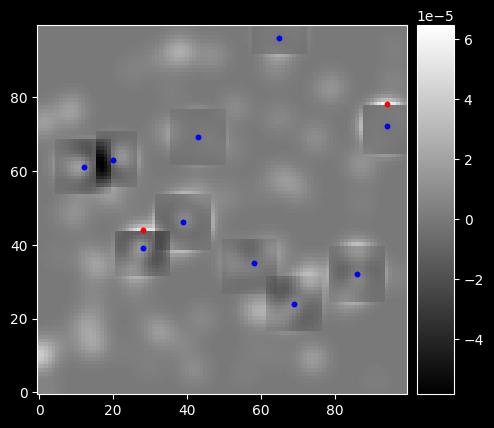

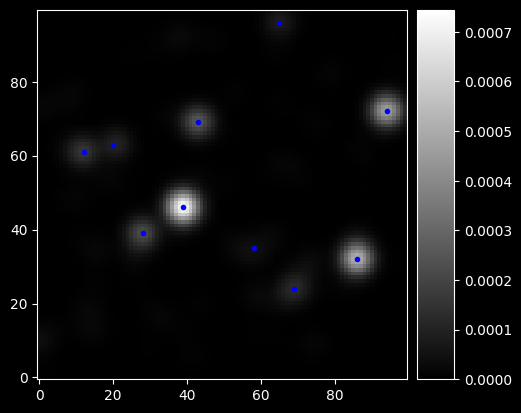


sigma0 = 2.600855472391387
XERR None

Fit results:
	mode : curve_fit
	k: 7.353130759884323690e-04 +/- 6.9e-21  -->  0.00 %	init : 0.00074
	sigma: 3.043567672811924751e+00 +/- 2.1e-17  -->  0.00 %	init : 2.6
	x0: 6.973627010237946067e+00 +/- 2.8e-17  -->  0.00 %	init : 7.0
	y0: 6.972045263175678187e+00 +/- 2.8e-17  -->  0.00 %	init : 7.0
	corr_k-sigma	 = -0.71
	corr_k-x0	 = 0.00025
	corr_k-y0	 = 0.00027
	corr_sigma-x0	 = -0.00043
	corr_sigma-y0	 = -0.00045
	corr_x0-y0	 = 1.9e-07

sigma0 = 2.600855472391387
XERR None

Fit results:
	mode : curve_fit
	k: 5.115677296338870441e-04 +/- 4.6e-21  -->  0.00 %	init : 0.00051
	sigma: 3.055891242889855697e+00 +/- 2.0e-17  -->  0.00 %	init : 2.6
	x0: 7.114503813269890564e+00 +/- 2.8e-17  -->  0.00 %	init : 7.0
	y0: 6.980705709648987067e+00 +/- 2.8e-17  -->  0.00 %	init : 7.0
	corr_k-sigma	 = -0.71
	corr_k-x0	 = -0.0011
	corr_k-y0	 = 0.00019
	corr_sigma-x0	 = 0.0019
	corr_sigma-y0	 = -0.00032
	corr_x0-y0	 = -6.2e-07

sigma0 = 2.600855472391387
XERR 

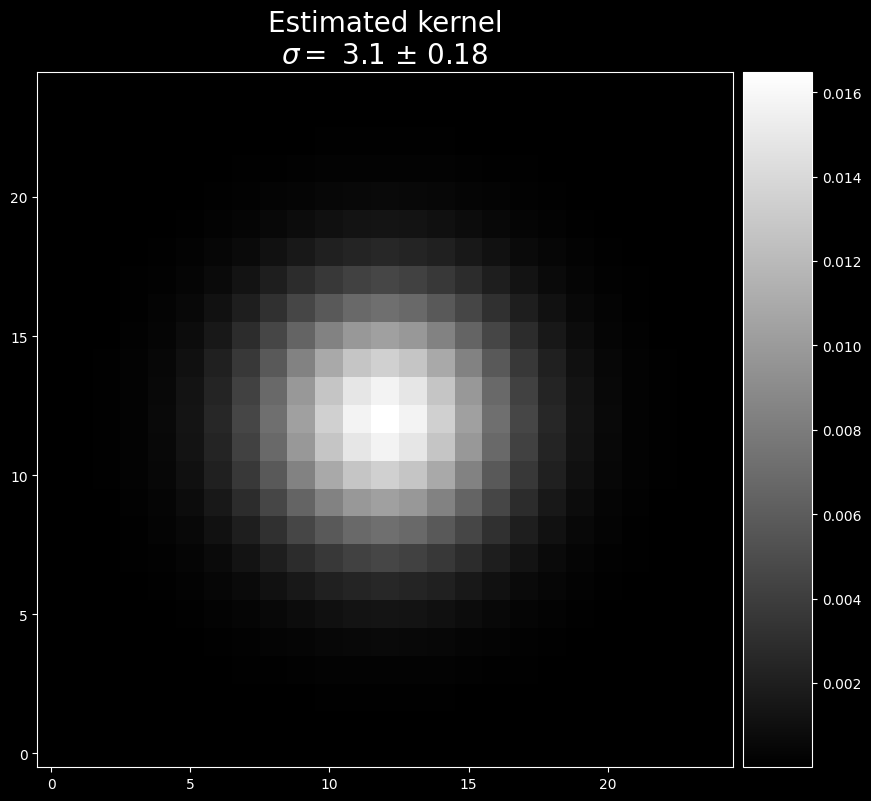

In [1]:
import skysimulation as sks
import numpy as np
import matplotlib.pyplot as plt

F,S =  sks.initialize()
Fseeing = sks.atm_seeing(F,bkg=sks.Gaussian(0,0))
fig, ax = plt.subplots(1,1)
sks.field_image(fig,ax,Fseeing)
plt.figure()
bkg = np.median(Fseeing)
plt.hist(Fseeing.flatten(),100)
plt.axvline(bkg,0,1)
plt.show()

obj,err,pos = sks.searching(Fseeing,bkg,bkg,num_objs=10,log=False)
sigma, Dsigma = sks.kernel_estimation(obj,err,(bkg,0))


Dn 0.0
Dn 0.0
Dn 0.0
2000: - diff 2.181e-06	chisq 4.579e-12
Time: 103.0886070728302 s



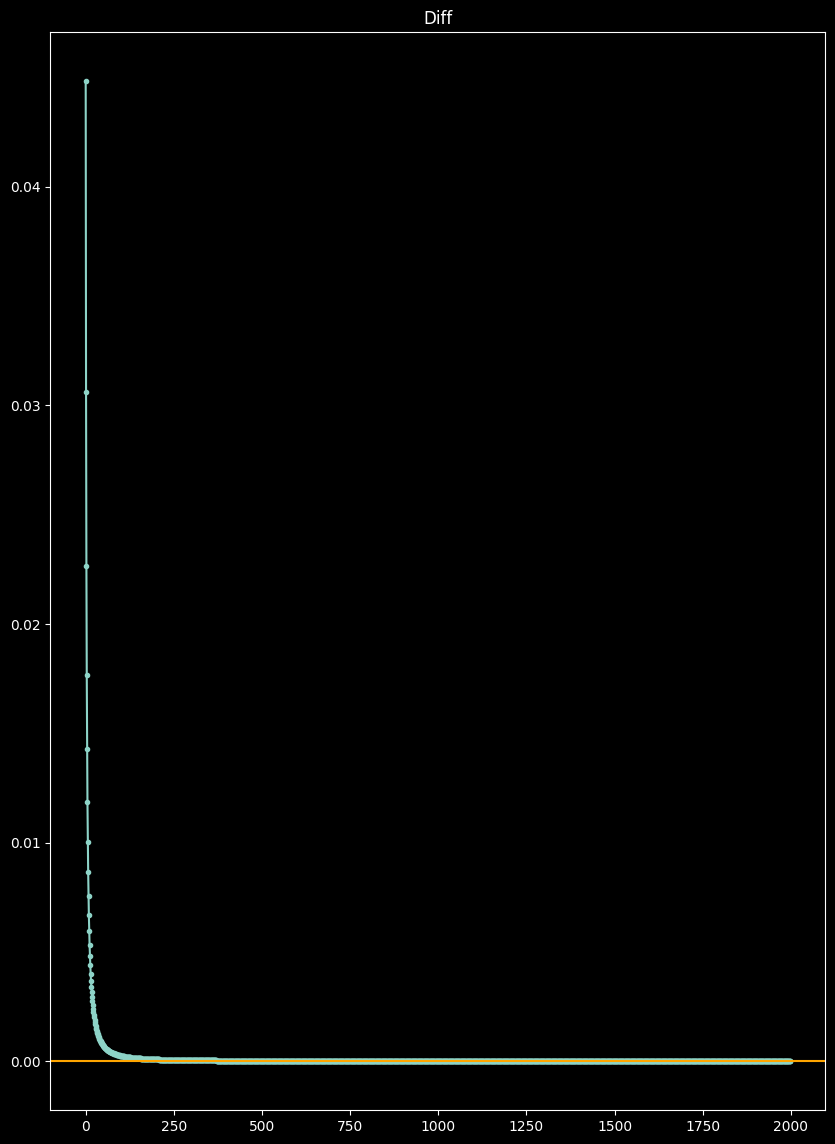

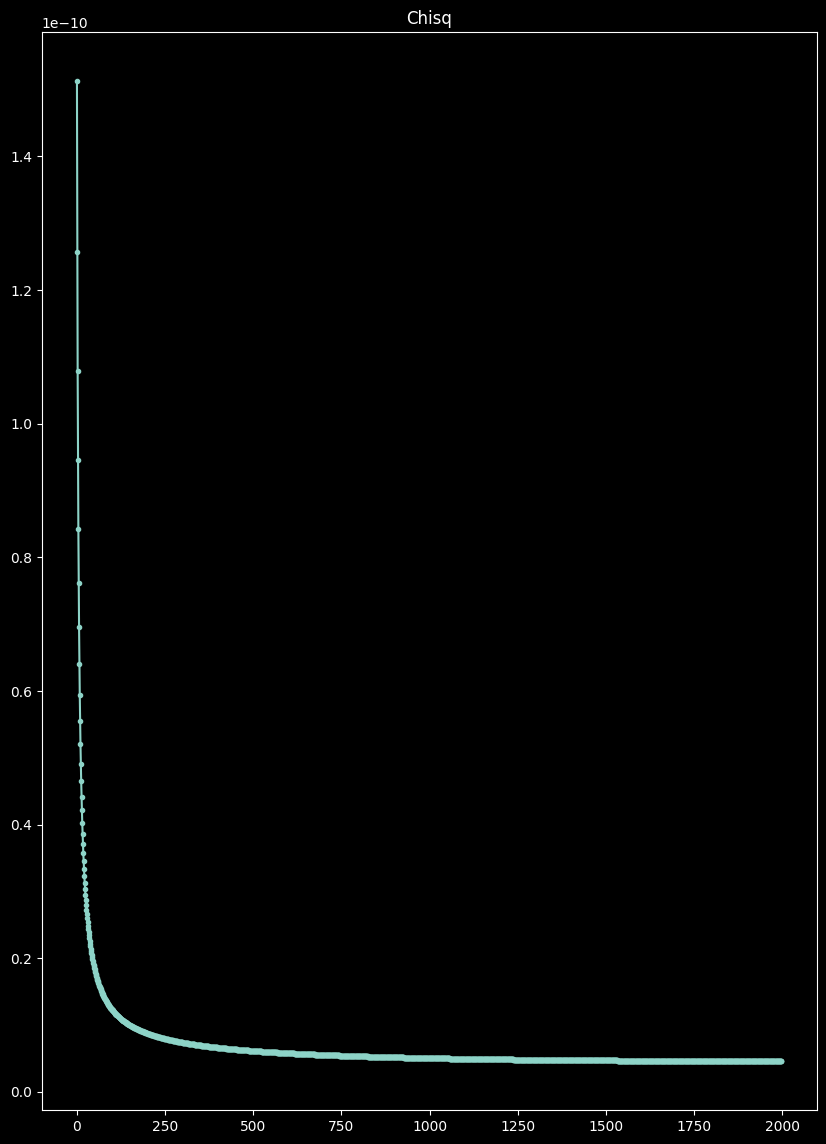

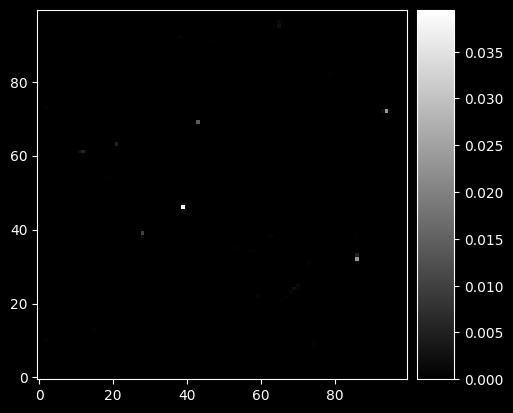

In [2]:
max_iter = 2000
mode = {'boundary':'symm'}
dec_field = sks.LR_deconvolution(Fseeing,sks.Gaussian(sigma),Fseeing*1e-1000,bkg,0,max_iter=max_iter,mode=mode)
fig, ax = plt.subplots(1,1)
sks.field_image(fig,ax,dec_field)
plt.show()



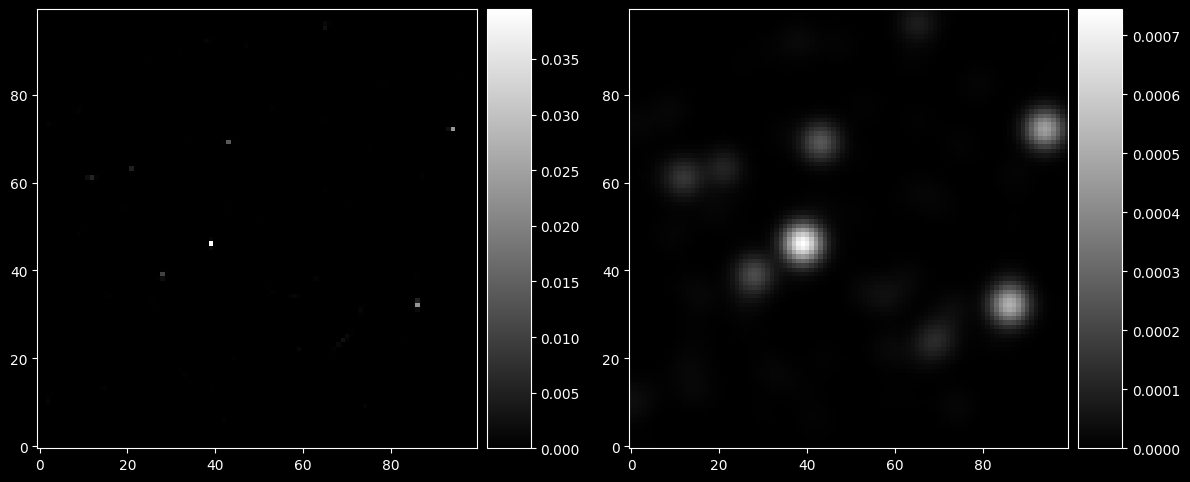

49.040799340956916
56.72741841473134
33.54101966249684
27.202941017470888
9.219544457292887
Remove
67.95586803212802
10.198039027185569
Remove
14.866068747318506
Remove
8.06225774829855
Remove
15.231546211727817
Remove
55.10898293381942
43.9089968002003
42.0
56.72741841473134
31.304951684997057
42.20189569201838
50.15974481593781
25.553864678361276
70.2922470831599
80.44874144447506
44.553338819890925
29.0
46.32493928760188
41.7612260356422
66.03029607687671
34.48187929913333
31.89043743820395
67.72001181334805
13.416407864998739
Remove
53.48831648126533
38.07886552931954
48.41487374764082
44.384682042344295
40.52159917870962
32.202484376209235
65.7875368135941
79.7057087039567
50.695167422546305
34.20526275297414
63.12685640834652
56.293871780150276
6.324555320336759
Remove
40.01249804748511
28.231188426986208
49.040799340956916
43.278170016764804
11.0
Remove
25.079872407968907
30.364452901377952
57.21887800367987
26.0
44.04543109109048
36.05551275463989
37.33630940518894
33.241540277

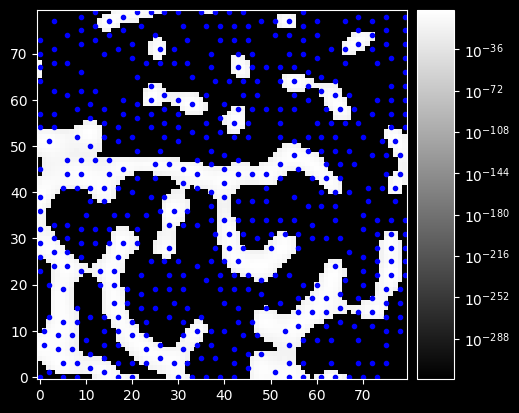

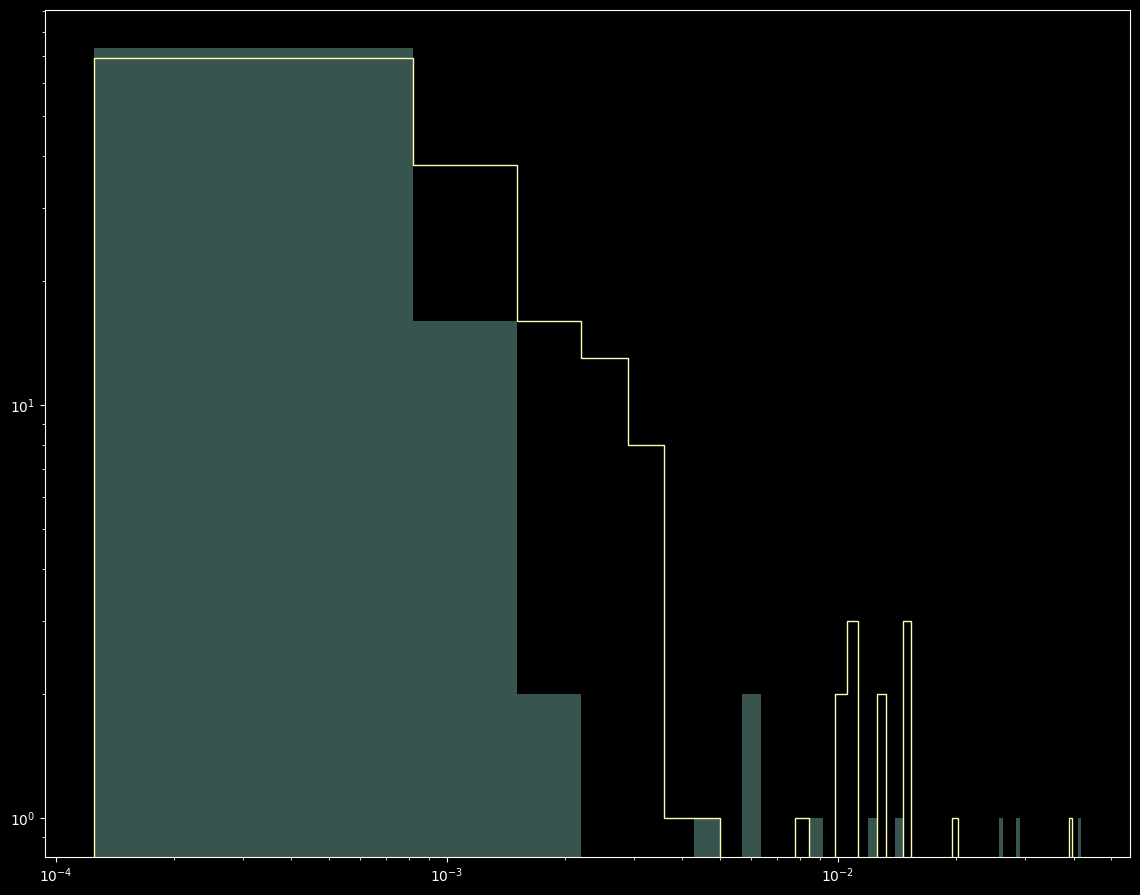

0.001920104809408659 0.0015294816650948926 20.34384489844947
100 507


In [42]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(14,11))
sks.field_image(fig,ax1,dec_field)
sks.field_image(fig,ax2,Fseeing)
plt.show()
tmp_S = dec_field[10:-10,10:-10]
objs = []
pos  = []
tmp = tmp_S.copy()
dist = lambda p1,p2: np.sqrt((p1[0]-p2[0])**2 + (p1[1]-p2[1])**2)
cnt = 0
xdim, ydim = tmp.shape
size = 2
for _ in range(2000):
    ipos = [*sks.peak_pos(tmp)]
    pos += [ipos]
    xends = (max(0,ipos[0]-size),min(xdim,ipos[0]+size+1))
    yends = (max(0,ipos[1]-size),min(ydim,ipos[1]+size+1))
    cut = (slice(*xends),slice(*yends))
    tmp[cut] = 0
    if cnt > 0: 
        p1 = pos[cnt-1]
        p2 = pos[cnt]
        print(dist(p1,p2))
        if dist(p1,p2) <= 20:
            print('Remove')
            pos.remove([*p2])
        else:
            # if cnt <= 3:
            #     sks.fast_image(tmp,norm='log')
            objs += [tmp_S[cut]]
            cnt += 1
    else:
        cnt+=1
fig, ax = plt.subplots(1,1)
sks.field_image(fig,ax,tmp_S,norm='log')
for p in pos:
    y,x = p
    ax.plot(x,y,'.b')
plt.show()

peaks = np.sort(np.array([o.max() for o in objs]))[::-1]*np.sqrt(2*np.pi*sigma**2)
lum = np.sort(S.lum)[::-1]

plt.figure(figsize=(14,11))
counts, bins, _ = plt.hist(lum,60,alpha=0.4)
plt.hist(peaks,bins,histtype='step')
plt.xscale('log')
plt.yscale('log')
plt.show()
print(lum.mean(),peaks.mean(),abs(lum.mean()-peaks.mean())/lum.mean()*100)
print(len(lum),len(peaks))
